<span style="color:blue">**Group 18 Phase 4 Project Submission**</span>

<span style="color:blue">**Student names:**</span>
1. Francis Njenga
2. Thomas Okiwi
2. Leonard Gachimu

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#REAL-TIME-PREDICTION-OF-BITCOIN-PRICES-IN-USD" data-toc-modified-id="REAL-TIME-PREDICTION-OF-BITCOIN-PRICES-IN-USD-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><span style="color:blue">REAL TIME PREDICTION OF BITCOIN PRICES IN USD</span></a></span></li><li><span><a href="#-PROJECT-OVERVIEW--" data-toc-modified-id="-PROJECT-OVERVIEW---2"><span class="toc-item-num">2&nbsp;&nbsp;</span><span style="color:blue"> PROJECT OVERVIEW </span> <a class="anchor" id="first-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#-BUSINESS-UNDERSTANDING--" data-toc-modified-id="-BUSINESS-UNDERSTANDING---3"><span class="toc-item-num">3&nbsp;&nbsp;</span><span style="color:blue"> BUSINESS UNDERSTANDING </span> <a class="anchor" id="second-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#A-Brief-Overview-of-Bitcoins-" data-toc-modified-id="A-Brief-Overview-of-Bitcoins--3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><strong><code>A Brief Overview of Bitcoins</code></strong> <a class="anchor" id="sixth-bullet" rel="nofollow"></a></a></span></li></ul></li><li><span><a href="#DATA-DESCRIPTION-" data-toc-modified-id="DATA-DESCRIPTION--4"><span class="toc-item-num">4&nbsp;&nbsp;</span><span style="color:blue">DATA DESCRIPTION</span> <a class="anchor" id="seventh-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#-BUSINESS-OBJECTIVE--" data-toc-modified-id="-BUSINESS-OBJECTIVE---5"><span class="toc-item-num">5&nbsp;&nbsp;</span><span style="color:blue"> BUSINESS OBJECTIVE </span> <a class="anchor" id="fifth-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#STUDY-QUESTIONS:-" data-toc-modified-id="STUDY-QUESTIONS:--5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><strong><code>STUDY QUESTIONS:</code></strong> <a class="anchor" id="sixth-bullet" rel="nofollow"></a></a></span></li></ul></li><li><span><a href="#PART-1:-EXPLORATORY-DATA-ANALYSIS-(EDA)-" data-toc-modified-id="PART-1:-EXPLORATORY-DATA-ANALYSIS-(EDA)--6"><span class="toc-item-num">6&nbsp;&nbsp;</span><span style="color:blue">PART 1: EXPLORATORY DATA ANALYSIS (EDA)</span> <a class="anchor" id="eighth-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#DATA-UNDERSTANDING-" data-toc-modified-id="DATA-UNDERSTANDING--6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span><span style="color:blue">DATA UNDERSTANDING</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#DATA-CLEANING-&amp;-TRANSFORMATION-" data-toc-modified-id="DATA-CLEANING-&amp;-TRANSFORMATION--6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span><span style="color:blue">DATA CLEANING &amp; TRANSFORMATION</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li></ul></li><li><span><a href="#PART-2:-TREND-AND-SEASONALITY-ANALYSIS-" data-toc-modified-id="PART-2:-TREND-AND-SEASONALITY-ANALYSIS--7"><span class="toc-item-num">7&nbsp;&nbsp;</span><span style="color:blue">PART 2: TREND AND SEASONALITY ANALYSIS</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#HANDLING-OUTLIERS-" data-toc-modified-id="HANDLING-OUTLIERS--7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span><span style="color:blue">HANDLING OUTLIERS</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#COLLINEARITY-ANALYSIS-" data-toc-modified-id="COLLINEARITY-ANALYSIS--7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span><span style="color:blue">COLLINEARITY ANALYSIS</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#Inspecting-Multicollinearity-" data-toc-modified-id="Inspecting-Multicollinearity--7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span><span style="color:blue">Inspecting Multicollinearity</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#Inspecting-Auto-Correlation-and-Partial-Autocorrelation-" data-toc-modified-id="Inspecting-Auto-Correlation-and-Partial-Autocorrelation--7.2.2"><span class="toc-item-num">7.2.2&nbsp;&nbsp;</span><span style="color:blue">Inspecting Auto Correlation and Partial Autocorrelation</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li></ul></li><li><span><a href="#TESTING-FOR-AND-REMOVING-TRENDS-" data-toc-modified-id="TESTING-FOR-AND-REMOVING-TRENDS--7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span><span style="color:blue">TESTING FOR AND REMOVING TRENDS</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#ROLLING-STATISTICS-METHOD-" data-toc-modified-id="ROLLING-STATISTICS-METHOD--7.3.1"><span class="toc-item-num">7.3.1&nbsp;&nbsp;</span><span style="color:blue">ROLLING STATISTICS METHOD</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#DICKEY-FULLER-TEST-" data-toc-modified-id="DICKEY-FULLER-TEST--7.3.2"><span class="toc-item-num">7.3.2&nbsp;&nbsp;</span><span style="color:blue">DICKEY FULLER TEST</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#TIME-SERIES-DECOMPOSITION-OF-THE-PRICE-FEATURE-" data-toc-modified-id="TIME-SERIES-DECOMPOSITION-OF-THE-PRICE-FEATURE--7.3.3"><span class="toc-item-num">7.3.3&nbsp;&nbsp;</span><span style="color:blue">TIME SERIES DECOMPOSITION OF THE PRICE FEATURE</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#1-LAG-DIFFERENCING-" data-toc-modified-id="1-LAG-DIFFERENCING--7.3.4"><span class="toc-item-num">7.3.4&nbsp;&nbsp;</span><span style="color:blue">1-LAG DIFFERENCING</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li></ul></li></ul></li><li><span><a href="#PART-3:-TIME-SERIES-MODELLING-" data-toc-modified-id="PART-3:-TIME-SERIES-MODELLING--8"><span class="toc-item-num">8&nbsp;&nbsp;</span><span style="color:blue">PART 3: TIME SERIES MODELLING</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#TRAIN-TEST-SPLIT-" data-toc-modified-id="TRAIN-TEST-SPLIT--8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span><span style="color:blue">TRAIN TEST SPLIT</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#BASELINE-ARIMA-MODEL-" data-toc-modified-id="BASELINE-ARIMA-MODEL--8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span><span style="color:blue">BASELINE ARIMA MODEL</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#SARIMAX-MODEL-" data-toc-modified-id="SARIMAX-MODEL--8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span><span style="color:blue">SARIMAX MODEL</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#FACEBOOK-PROPHET-MODEL-" data-toc-modified-id="FACEBOOK-PROPHET-MODEL--8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span><span style="color:blue">FACEBOOK PROPHET MODEL</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#VECTOR-AUTOREGRESSIVE-(VAR)-MODEL-" data-toc-modified-id="VECTOR-AUTOREGRESSIVE-(VAR)-MODEL--8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span><span style="color:blue">VECTOR AUTOREGRESSIVE (VAR) MODEL</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#Forecast-Comparison-Plot:" data-toc-modified-id="Forecast-Comparison-Plot:-8.5.1"><span class="toc-item-num">8.5.1&nbsp;&nbsp;</span><span style="color:blue">Forecast Comparison Plot:</span></a></span></li><li><span><a href="#Residual-visualization" data-toc-modified-id="Residual-visualization-8.5.2"><span class="toc-item-num">8.5.2&nbsp;&nbsp;</span><span style="color:blue">Residual visualization</span></a></span></li></ul></li><li><span><a href="#MULTIVARIATE-LONG-SHORT-TERM-MEMORY-NETWORK-(LSTM)-MODEL-" data-toc-modified-id="MULTIVARIATE-LONG-SHORT-TERM-MEMORY-NETWORK-(LSTM)-MODEL--8.6"><span class="toc-item-num">8.6&nbsp;&nbsp;</span><span style="color:blue">MULTIVARIATE LONG SHORT-TERM MEMORY NETWORK (LSTM) MODEL</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#VANILLA-(SINGLE-LAYER)-LSTM-MODEL-" data-toc-modified-id="VANILLA-(SINGLE-LAYER)-LSTM-MODEL--8.6.1"><span class="toc-item-num">8.6.1&nbsp;&nbsp;</span><span style="color:blue">VANILLA (SINGLE LAYER) LSTM MODEL</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#STACKED-LSTM-MODEL-" data-toc-modified-id="STACKED-LSTM-MODEL--8.6.2"><span class="toc-item-num">8.6.2&nbsp;&nbsp;</span><span style="color:blue">STACKED LSTM MODEL</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#BIDIRECTIONAL-LSTM-MODEL-" data-toc-modified-id="BIDIRECTIONAL-LSTM-MODEL--8.6.3"><span class="toc-item-num">8.6.3&nbsp;&nbsp;</span><span style="color:blue">BIDIRECTIONAL LSTM MODEL</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li></ul></li></ul></li><li><span><a href="#PART-4:-MODEL-DEPLOYMENT-" data-toc-modified-id="PART-4:-MODEL-DEPLOYMENT--9"><span class="toc-item-num">9&nbsp;&nbsp;</span><span style="color:blue">PART 4: MODEL DEPLOYMENT</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span><ul class="toc-item"><li><span><a href="#TEST-CODE-FOR-SCRAPING-REAL-TIME-DATA-AND-FORECASTING-PRICES-" data-toc-modified-id="TEST-CODE-FOR-SCRAPING-REAL-TIME-DATA-AND-FORECASTING-PRICES--9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span><span style="color:blue">TEST CODE FOR SCRAPING REAL-TIME DATA AND FORECASTING PRICES</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#WEB-SERVER-DEPLOYMENT-CODE-" data-toc-modified-id="WEB-SERVER-DEPLOYMENT-CODE--9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span><span style="color:blue">WEB SERVER DEPLOYMENT CODE</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li></ul></li><li><span><a href="#CONCLUSION-" data-toc-modified-id="CONCLUSION--10"><span class="toc-item-num">10&nbsp;&nbsp;</span><span style="color:blue">CONCLUSION</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#LIMITATIONS/-ASSUMPTIONS-" data-toc-modified-id="LIMITATIONS/-ASSUMPTIONS--11"><span class="toc-item-num">11&nbsp;&nbsp;</span><span style="color:blue">LIMITATIONS/ ASSUMPTIONS</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#RECOMMENDATIONS-FOR-FUTURE-MODELLING-" data-toc-modified-id="RECOMMENDATIONS-FOR-FUTURE-MODELLING--12"><span class="toc-item-num">12&nbsp;&nbsp;</span><span style="color:blue">RECOMMENDATIONS FOR FUTURE MODELLING</span> <a class="anchor" id="ninth-bullet" rel="nofollow"></a></a></span></li></ul></div>

## <span style="color:blue">REAL TIME PREDICTION OF BITCOIN PRICES IN USD</span>

## <span style="color:blue"> PROJECT OVERVIEW </span> <a class="anchor" id="first-bullet"></a>
In this project, we intend to develop a time series model for predicting daily bictoin vs USD exchange rate up to the number of days that a user wants.

## <span style="color:blue"> BUSINESS UNDERSTANDING </span> <a class="anchor" id="second-bullet"></a>

In the dynamic realm of forex and cryptocurrency trading, delving into the intricacies of the bitcoin exchange rate requires a blend of technical prowess and market intuition. At its core, a forex company's success hinges on its ability to decipher patterns, derive insights, and make informed decisions in the volatile landscape of cryptocurrencies.

To embark on this data science journey, one must first acknowledge the unique nature of BTC/USD trading. Unlike traditional fiat currencies, Bitcoin operates in a decentralized ecosystem, susceptible to a myriad of factors ranging from market sentiment to regulatory developments. As such, any comprehensive analysis must transcend traditional forex metrics and incorporate the idiosyncrasies of the cryptocurrency market.

Fundamental analysis is a key pillar in understanding the dynamics of BTC/USD. Factors such as macroeconomic indicators, regulatory shifts, and technological advancements play a pivotal role in shaping Bitcoin's value. The global economic landscape, inflationary pressures, and institutional adoption are variables that demand meticulous examination.

On the technical front, deploying advanced algorithms and machine learning models becomes imperative. Time series analysis, sentiment analysis, and pattern recognition algorithms can unravel hidden trends within the price movements of BTC/USD. As cryptocurrencies often exhibit distinct behavioral patterns, these models can offer a predictive edge, allowing the forex company to stay ahead of market fluctuations.

Risk management is another critical facet that cannot be understated. The inherent volatility of BTC/USD necessitates robust risk mitigation strategies. Utilizing data-driven insights, a forex company can optimize position sizing, set stop-loss levels, and establish risk-reward ratios tailored to the unique characteristics of the cryptocurrency market.

Furthermore, the integration of real-time data feeds and APIs is paramount for staying abreast of market developments. In the fast-paced world of forex, timely and accurate information can make the difference between seizing an opportincurring a loss.

### **`A Brief Overview of Bitcoins`** <a class="anchor" id="sixth-bullet"></a>

Bitcoin is the first decentralized cryptocurrency. Nodes in the peer-to-peer bitcoin network verify transactions through cryptography and record them in a public distributed ledger, called a blockchain, without central oversight.

It was invented in 2008 by [Satoshi Nakamoto](https://en.wikipedia.org/wiki/Satoshi_Nakamoto), an anonymous person and its use as a currency began in 2009.

In 2010, the first known [commercial transaction](https://en.wikipedia.org/wiki/Financial_transaction) using bitcoin occurred when programmer Laszlo Hanyecz bought two [Papa John's](https://en.wikipedia.org/wiki/Papa_John%27s) pizzas for \₿10,000. 

## <span style="color:blue">DATA DESCRIPTION</span> <a class="anchor" id="seventh-bullet"></a>
The dataset is obtained by scraping USD/bitcoin history data from https://investing.com/. Trading of bitcoins started in 2010, and therefore the dataset starts from 18th July 2010 up to the day of scraping. 

Key metrics such as opening, closing, high, and low prices, along with trading volume and daily percentage changes, provide insights into the cryptocurrency's behavior.

## <span style="color:blue"> BUSINESS OBJECTIVE </span> <a class="anchor" id="fifth-bullet"></a>
Our main objective is to develop a time series model that can accurately predict and plot the daily bictoin vs USD exchange rate at least 6 weeks ahead and up to the number of days that a user wants.

### **`STUDY QUESTIONS:`** <a class="anchor" id="sixth-bullet"></a>
1. Is it possible to predict bitcoin prices in USD at least 6 weeks ahead?
2. Which specific historical and external factors contribute significantly to BTC-USD forecasting accuracy?
3. Can the time series model ensure real-time responsiveness and adaptability to gradual and sudden changes in the cryptocurrency market for BTC-USD?

## <span style="color:blue">PART 1: EXPLORATORY DATA ANALYSIS (EDA)</span> <a class="anchor" id="eighth-bullet"></a>
In this section, we will familiarize ourselves with the various features in the data, clean and tranform some of the features appropritely.

### <span style="color:blue">DATA UNDERSTANDING</span> <a class="anchor" id="ninth-bullet"></a>

In [56]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from prophet import Prophet
from pmdarima import auto_arima

import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

import streamlit as st
import joblib

import warnings
# Ignore documentation warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sphinx')

In [57]:
bitcoin_df= pd.read_csv("BTC_USD_Historical_Data.csv")

# Print the first 5 rows
bitcoin_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,11/29/2023,"38,046.70","37,823.30","38,362.90","37,686.50",67.23K,0.59%
1,11/28/2023,"37,823.30","37,244.30","38,379.40","36,881.10",57.50K,1.54%
2,11/27/2023,"37,248.60","37,451.80","37,563.30","36,751.50",45.24K,-0.54%
3,11/26/2023,"37,451.80","37,786.40","37,819.10","37,166.30",29.20K,-0.89%
4,11/25/2023,"37,787.00","37,718.60","37,887.40","37,599.90",16.09K,0.18%


In [58]:
# View the data schema and data types
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4883 entries, 0 to 4882
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      4883 non-null   object
 1   Price     4883 non-null   object
 2   Open      4883 non-null   object
 3   High      4883 non-null   object
 4   Low       4883 non-null   object
 5   Vol.      4877 non-null   object
 6   Change %  4883 non-null   object
dtypes: object(7)
memory usage: 267.2+ KB


In [59]:
# Number of missing values in dataframe
bitcoin_df.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
dtype: int64

### <span style="color:blue">DATA CLEANING & TRANSFORMATION</span> <a class="anchor" id="ninth-bullet"></a>

Since the values in volumn column are currently object type with irregular characters, it is not possible to compute measures of central tendency or plot a distribution of the values.
We therefore, cannot statitically determine what to replace the missing values with and since they are only 6 out of 4,883 rows, we choose to delete them.

In [60]:
# Delete rows with missing values
bitcoin_df.dropna(inplace=True)

Inspect the value counts in volume column

In [61]:
bitcoin_df['Vol.'].value_counts()

Vol.
1.05M      6
1.04M      5
14.73K     5
1.18M      5
1.11M      4
          ..
956.52K    1
840.76K    1
747.71K    1
738.17K    1
0.08K      1
Name: count, Length: 4335, dtype: int64

The volume column has several unique values and we notice that they are ending with letters such as K and M to denote multiples of thousands, millions, and so on.
We will use a regex function to extract all the unique suffixes and one representative value per suffix. 

In [62]:
# Import regex
import re

# Extract rows with suffix letters using a regex expression
suffixes = bitcoin_df['Vol.'].str.extract(r'(\D+)$')[0]

# Create a dictionary to store unique values for each suffix
unique_values = {}
for suffix in suffixes.unique():
    # Get values with the current suffix
    values_with_suffix = bitcoin_df[bitcoin_df['Vol.'].str.endswith(suffix)]['Vol.']
    # Get the first value for the suffix
    representative_value = values_with_suffix.iloc[0]
    unique_values[suffix] = representative_value

# Print the unique values for each suffix
for suffix, value in unique_values.items():
    print(f"Suffix {suffix}: {value}")
    
# Print rows without a suffix letter in the volume column
bitcoin_df[~(bitcoin_df['Vol.'].str.contains(r'(\D+)$'))]

Suffix K: 67.23K
Suffix M: 671.05M
Suffix B: 1.04B


C:\Users\USER PC\AppData\Local\Temp\ipykernel_2728\1536275681.py:21: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,Date,Price,Open,High,Low,Vol.,Change %


There are no values without a suffix letter. We will next strip the suffix letters, convert the remaining number to a float type and multiply it with the corresponding multiplier for the letter.

In [63]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4877 entries, 0 to 4882
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      4877 non-null   object
 1   Price     4877 non-null   object
 2   Open      4877 non-null   object
 3   High      4877 non-null   object
 4   Low       4877 non-null   object
 5   Vol.      4877 non-null   object
 6   Change %  4877 non-null   object
dtypes: object(7)
memory usage: 304.8+ KB


In [64]:
# Strip suffix letters from volume column and convert to respective numeric figure
for index, row in bitcoin_df.iterrows():
    if 'K' in row['Vol.']:
        row_value = round(float(row['Vol.'].strip('K')) * 1000)
        bitcoin_df.at[index, 'Vol.'] = row_value
    elif 'M' in row['Vol.']:
        row_value = round(float(row['Vol.'].strip('M')) * 1000000)
        bitcoin_df.at[index, 'Vol.'] = row_value
    elif 'B' in row['Vol.']:
        row_value = round(float(row['Vol.'].strip('B')) * 1000000000)
        bitcoin_df.at[index, 'Vol.'] = row_value  

In [65]:
# Remove commas from specified columns
bitcoin_df[['Price', 'Open', 'High', 'Low']] = bitcoin_df[['Price', 
                                                 'Open', 'High', 
                                                 'Low']].replace({',': ''}, regex=True)


# Remove percentage sign from the 'Change' column
bitcoin_df['Change %'] = bitcoin_df['Change %'].str.replace('%', '')

# Convert specified columns to float
bitcoin_df[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']] = bitcoin_df[['Price', 
                                                                     'Open', 'High', 'Low', 
                                                                     'Vol.', 'Change %']].astype(float)

In [66]:
# Check for duplicates
bitcoin_df.duplicated().sum()

0

In [67]:
# Confirm data type change
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4877 entries, 0 to 4882
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      4877 non-null   object 
 1   Price     4877 non-null   float64
 2   Open      4877 non-null   float64
 3   High      4877 non-null   float64
 4   Low       4877 non-null   float64
 5   Vol.      4877 non-null   float64
 6   Change %  4877 non-null   float64
dtypes: float64(6), object(1)
memory usage: 433.9+ KB


Converting Data to Time Series

In [68]:
# Convert Date column to time series and set it as the index
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])

# Sort by date in descending order
bitcoin_df.sort_values(by='Date', ascending=True, inplace=True)

# Set date column as the index
bitcoin_df.set_index('Date', inplace=True)

# View the first 5 rows
bitcoin_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0


In [69]:
# Confirm data type change
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4877 entries, 2010-07-18 to 2023-11-29
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     4877 non-null   float64
 1   Open      4877 non-null   float64
 2   High      4877 non-null   float64
 3   Low       4877 non-null   float64
 4   Vol.      4877 non-null   float64
 5   Change %  4877 non-null   float64
dtypes: float64(6)
memory usage: 266.7 KB


## <span style="color:blue">PART 2: TREND AND SEASONALITY ANALYSIS</span> <a class="anchor" id="ninth-bullet"></a>

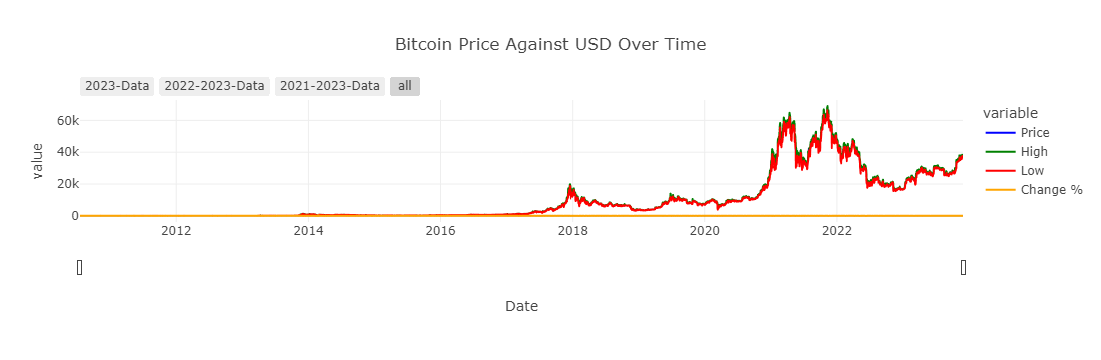

In [70]:
# Visualize a navigable series
import plotly.express as px

fig = px.line(bitcoin_df, y=['Price', 'High', 'Low', 'Change %'],
              color_discrete_map={'Price': 'blue', 'High': 'green', 'Low': 'red', 'Change %': 'orange'},
              title='Bitcoin Price Against USD Over Time')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='2023-Data', step='year', stepmode='backward'),
            dict(count=2, label='2022-2023-Data', step='year', stepmode='backward'),
            dict(count=3, label='2021-2023-Data', step='year', stepmode='backward'),
            dict(step='all')
        ])
    )
)

fig.show()

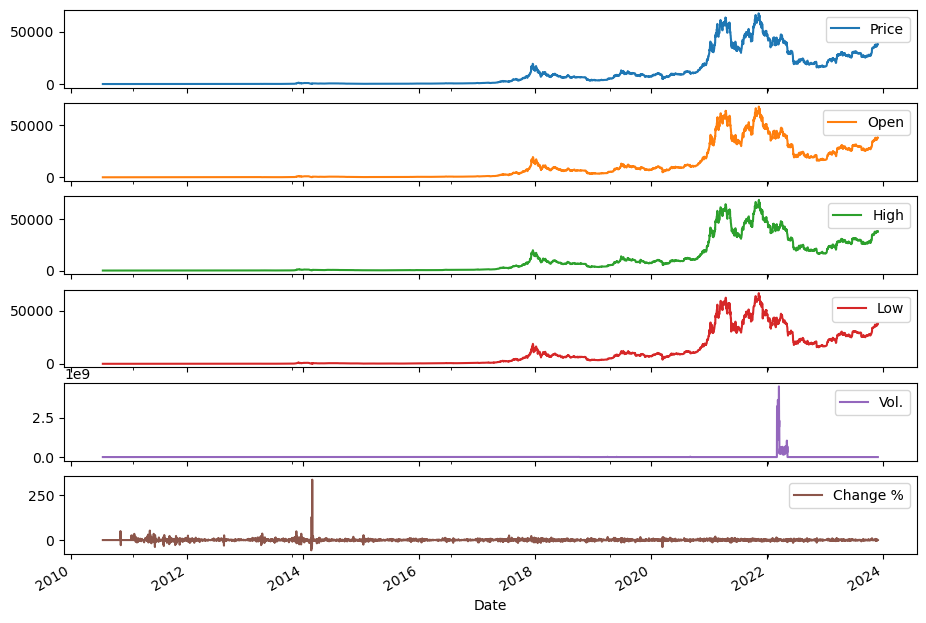

In [71]:
# Plot the time series for Price, Open, High, Low, Vol., and Change % features
bitcoin_df.plot(figsize = (11,8), subplots=True, legend=True);

Price, Open, High, Low follow the same trend and magnitude, while volume and Change (%) have their own unique trends and scales.
We will plot the features on same x-axis but different scales.

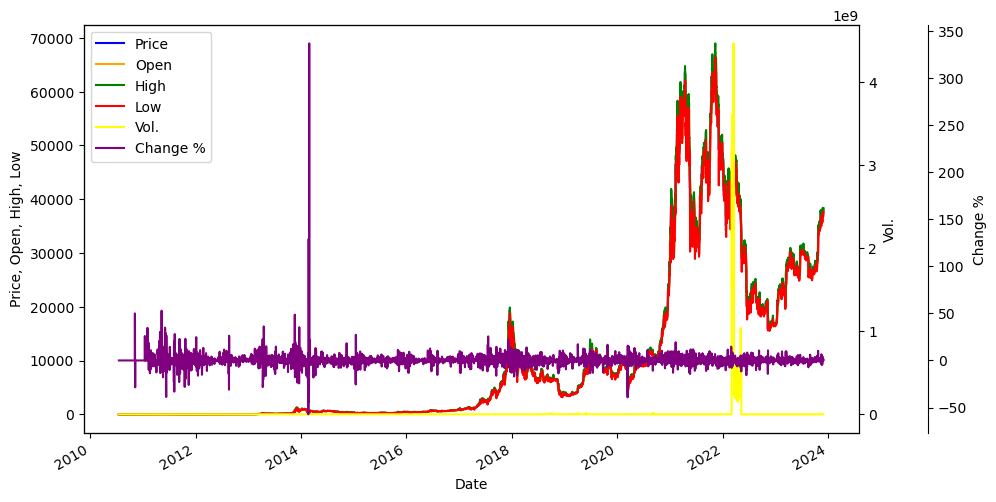

In [72]:
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting 'Price', 'Open', 'High', 'Low' on the first axis
bitcoin_df[['Price', 'Open', 'High', 'Low']].plot(ax=ax1, color=['blue', 'orange', 'green', 'red'])
ax1.set_ylabel('Price, Open, High, Low')

# Create a second y-axis for 'Vol.'
ax2 = ax1.twinx()
bitcoin_df['Vol.'].plot(ax=ax2, color='yellow')
ax2.set_ylabel('Vol.')

# Create a third y-axis for 'Change %'
ax3 = ax1.twinx()
bitcoin_df['Change %'].plot(ax=ax3, color='purple')
ax3.spines['right'].set_position(('outward', 50))  # Adjust position for 'Change %' axis
ax3.set_ylabel('Change %')

# Adjusting layout and legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
ax1.legend(lines, labels, loc='upper left');

### <span style="color:blue">HANDLING OUTLIERS</span> <a class="anchor" id="ninth-bullet"></a>

We do notice unusual spikes in the change and volume features.
When confronted with a time series shock, the [forecast of some time series models such as ARIMA becomes too wide for any meaningful prediction](https://iopscience.iop.org/article/10.1088/1742-6596/954/1/012010/pdf).

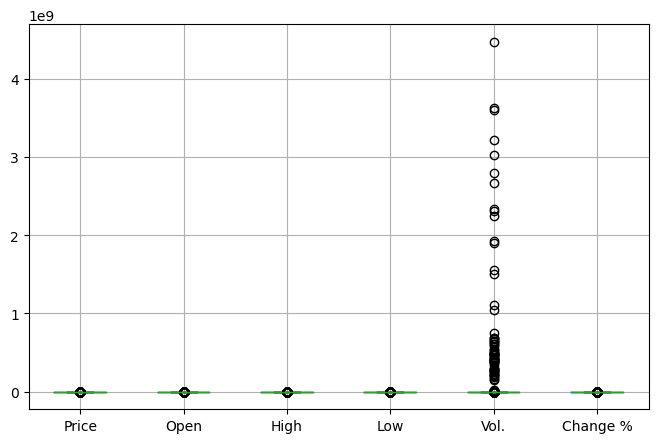

In [73]:
bitcoin_df.boxplot(figsize = (8,5));

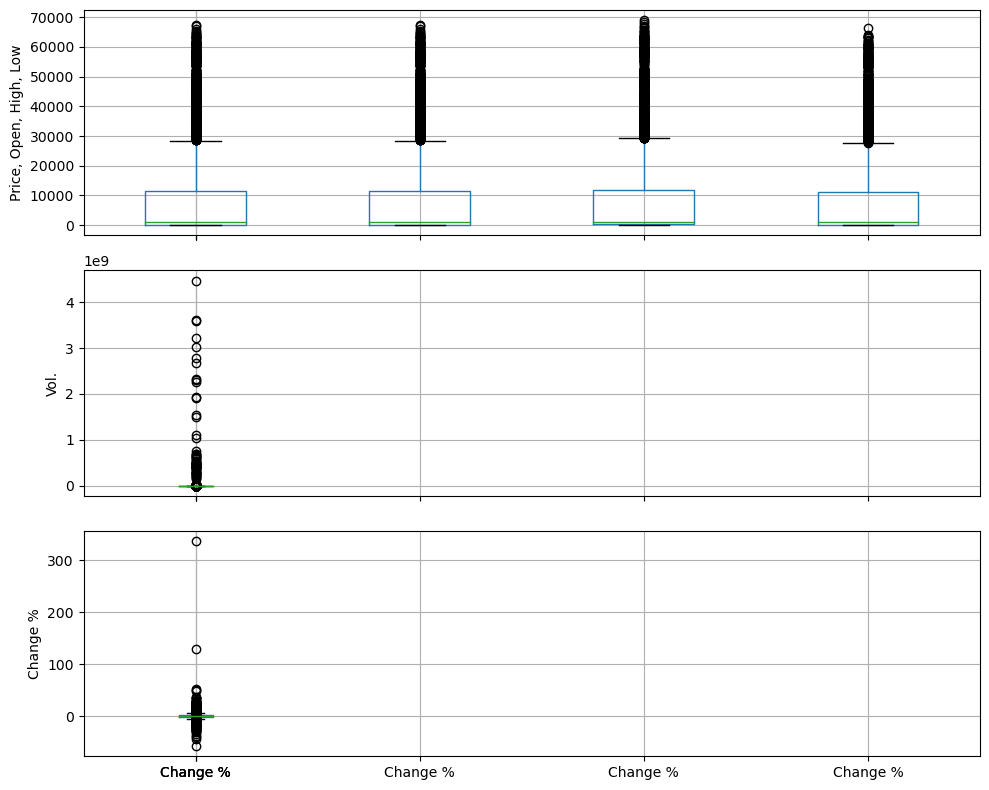

In [74]:
# Create a figure and axes
fig, axs = plt.subplots(nrows=3, figsize=(10, 8), sharex=True)

# Plot boxplots for 'Price', 'Open', 'High', 'Low' in the first subplot
bitcoin_df[['Price', 'Open', 'High', 'Low']].boxplot(ax=axs[0])
axs[0].set_ylabel('Price, Open, High, Low')

# Plot boxplot for 'Vol.' in the second subplot
bitcoin_df[['Vol.']].boxplot(ax=axs[1])
axs[1].set_ylabel('Vol.')

# Plot boxplot for 'Change %' in the third subplot
bitcoin_df[['Change %']].boxplot(ax=axs[2])
axs[2].set_ylabel('Change %')

plt.tight_layout();

Volume and Change columns have significant outliers.
We choose to filter the outliers because of the following reasons:

1.) Even though Bitcoin is generally volatile, each of the two columns has an unusual spike only once for the 13 year period. Therefore, such spikes are unlikely to become regular. In fact, reports show that the unsual spike in Bitcoin trade volumes in 2022 was accompanied (although not provably influenced) by unique events such as the Russian invasion of Ukraine in February, 2022 and [the collapse of FTX Trading Ltd.](https://www.reuters.com/technology/crypto-market-still-bears-scars-ftxs-collapse-2023-10-03/), a fraud-ridden cryptocurrency exchange and crypto hedge fund. 

2.) The presence of significant outliers in the dataset could skew the results and reduce model accuracy.

<img src="images/recent_bitcoin_price_trend.png" width=800>

In [75]:
# Identify outliers in volume and change columns

# Calculate the quartiles
Q1_vol = bitcoin_df['Vol.'].quantile(0.25)
Q3_vol = bitcoin_df['Vol.'].quantile(0.75)
Q1_change = bitcoin_df['Change %'].quantile(0.25)
Q3_change = bitcoin_df['Change %'].quantile(0.75)

# Calculate the interquartile ranges (IQR)
IQR_vol = Q3_vol - Q1_vol
IQR_change = Q3_change - Q1_change

# Set the lower and upper fence for outlier detection
lower_fence_vol = Q1_vol - (1.5 * IQR_vol)
upper_fence_vol = Q3_vol + (1.5 * IQR_vol)
lower_fence_change = Q1_change - (1.5 * IQR_change)
upper_fence_change = Q3_change + (1.5 * IQR_change)

print('lower_fence for volume =' , lower_fence_vol)
print('upper_fence for volume =', upper_fence_vol)
print('lower_fence for change =' , lower_fence_change)
print('upper_fence for change =', upper_fence_change)

# Find number of entries with outliers
vol_outliers = bitcoin_df[(bitcoin_df['Vol.'] < lower_fence_vol) | 
                     (bitcoin_df['Vol.'] > upper_fence_vol)]
               
change_outliers = bitcoin_df[(bitcoin_df['Change %'] < lower_fence_change) |
                        (bitcoin_df['Change %'] > upper_fence_change)]
               
# Print number of outliers              
print('Number of volume outliers:' , len(vol_outliers))
print('Number of change outliers:' , len(change_outliers))

lower_fence for volume = -209975.0
upper_fence for volume = 433985.0
lower_fence for change = -5.645
upper_fence for change = 6.235
Number of volume outliers: 734
Number of change outliers: 614


Applying the interquartile range would filter a high number of values and so we will go back to inspecting the box plots visually. 

For the Volume column, most of the values are concentrated below 1,000,000,000 and there only a handlful of values above this point. We will therefore remove rows where the volume is above 1,000,000,000.

For the Change column, most of the values are concentrated above -50% and below 50%. We will therefore, filter rows with below -50% and above 50% change.

In [76]:
# Filter rows with volume above 1000,000,000
bitcoin_df = bitcoin_df[bitcoin_df['Vol.'] < 1000000000]

# Filter rows with change below -50% and above 50%
bitcoin_df = bitcoin_df[(bitcoin_df['Change %'] > -50) & (bitcoin_df['Change %'] < 50)]

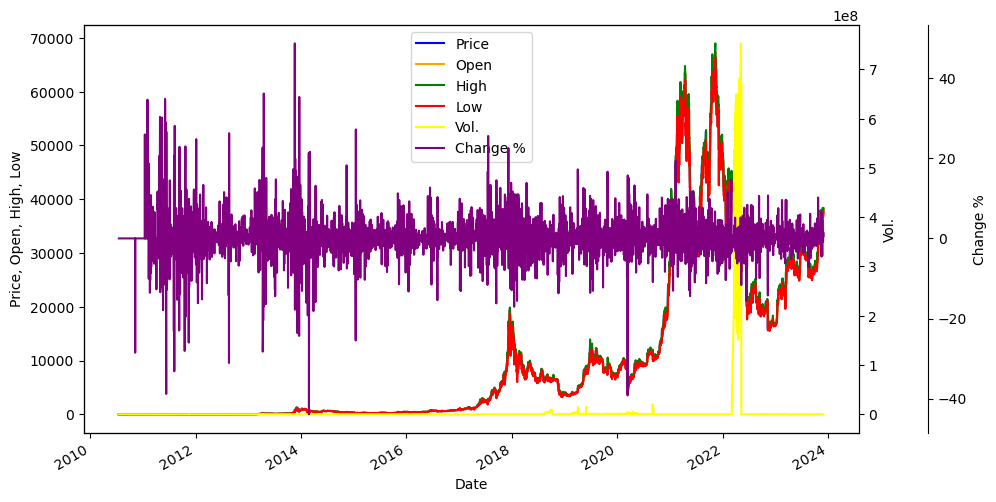

In [77]:
# Plot the filtered time series
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting 'Price', 'Open', 'High', 'Low' on the first axis
bitcoin_df[['Price', 'Open', 'High', 'Low']].plot(ax=ax1, color=['blue', 'orange', 'green', 'red'])
ax1.set_ylabel('Price, Open, High, Low')

# Create a second y-axis for 'Vol.'
ax2 = ax1.twinx()
bitcoin_df['Vol.'].plot(ax=ax2, color='yellow')
ax2.set_ylabel('Vol.')

# Create a third y-axis for 'Change %'
ax3 = ax1.twinx()
bitcoin_df['Change %'].plot(ax=ax3, color='purple')
ax3.spines['right'].set_position(('outward', 50))  # Adjust position for 'Change %' axis
ax3.set_ylabel('Change %')

# Adjusting layout and legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
ax1.legend(lines, labels, loc='upper center');

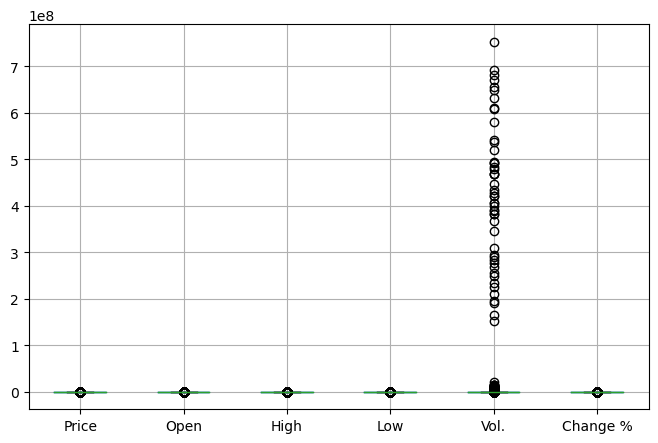

In [78]:
# Plot a boxplot
bitcoin_df.boxplot(figsize = (8,5));

The voulme column still has outliers and from inspecting the boxplot, we will filter the rows with a volume above 50,000,000 

In [79]:
# Filter rows with volume above 50,000,000
bitcoin_df = bitcoin_df[bitcoin_df['Vol.'] < 50000000]

### <span style="color:blue">COLLINEARITY ANALYSIS</span> <a class="anchor" id="ninth-bullet"></a>
#### <span style="color:blue">Inspecting Multicollinearity</span> <a class="anchor" id="ninth-bullet"></a>

The columns 'Price', 'Open', 'High', and 'Low' are visually correlated but we will inspect whether they're actually correlation or not.

In [80]:
# View the correlation matrix
bitcoin_df.corr()

,Price,Open,High,Low,Vol.,Change %
Price,1.000000,0.999028,0.999556,0.999454,-0.007800,-0.010004
Open,0.999028,1.000000,0.999564,0.999223,-0.007485,-0.029365
High,0.999556,0.999564,1.000000,0.999081,-0.007115,-0.019313
Low,0.999454,0.999223,0.999081,1.000000,-0.008559,-0.017807
Vol.,-0.007800,-0.007485,-0.007115,-0.008559,1.000000,-0.005414
Change %,-0.010004,-0.029365,-0.019313,-0.017807,-0.005414,1.000000


There is near-perfect correlation between 'Price', 'Open', 'High', and 'Low'. 
There is neglible correlation between volume and any other feature and between Change and any other feature.

We will therefore, let 'Price' represent 'Open', 'High', and 'Low' and retain volume and change features.

In [81]:
# Remove 'Open', 'High', and 'Low' columns
bitcoin_df.drop(['Open', 'High', 'Low'], axis=1, inplace=True)

Will save the currently preprocessed file for deployment purpose

In [82]:
# Save the preprocessed dataset
bitcoin_df.to_csv('bitcoin_data.csv')

In [83]:
# Detrend the data to see whether collinearity between volume and change will
# change significantly
bitcoin_diff = bitcoin_df.diff(periods=1)

In [84]:
# View the correlation matrix of differenced time series
bitcoin_diff.corr()

,Price,Vol.,Change %
Price,1.000000,0.001570,0.316959
Vol.,0.001570,1.000000,0.009123
Change %,0.316959,0.009123,1.000000


Even after detrending, there is still low correlation between price, volume, and change. We will therefore, retain the three columns as each of them may have significant influence to the performance of our time series model.

#### <span style="color:blue">Inspecting Auto Correlation and Partial Autocorrelation</span> <a class="anchor" id="ninth-bullet"></a>

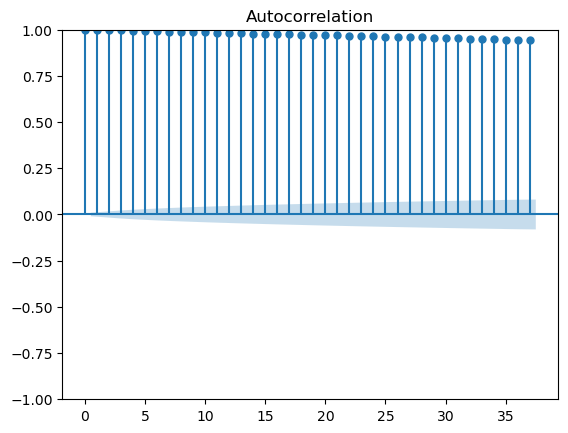

In [85]:
# Auto Correlation
from statsmodels.graphics.tsaplots import plot_acf

# ploting autocorelaton for each lag
plot_acf(bitcoin_df.Price[: -1], alpha= 0.5);

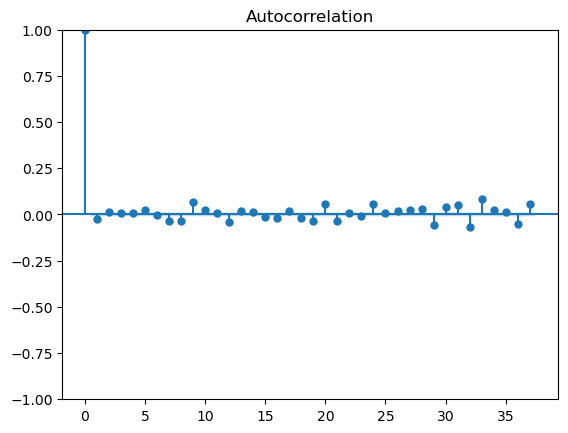

In [86]:
# Plotting differenced autocorelaton for each lag

# Differencing the price feature
price_diff = bitcoin_df['Price'].diff(periods=1)

plot_acf(price_diff.dropna()[: -1], alpha= 0.5);

The differenced auto correlation of price is not statistically significant. This means that the present price is not a significant indicator of the future price.

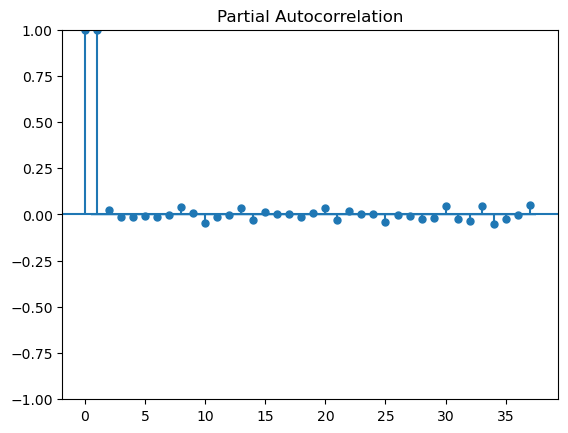

In [87]:
# Partial auto correlation
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(bitcoin_df.Price [: -1], alpha= 0.5);

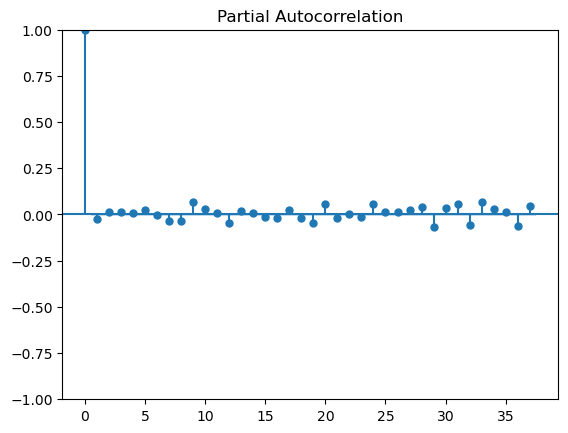

In [88]:
# Partial auto correlation of differenced price
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(price_diff.dropna(), alpha= 0.5);

There is significant partial autocorrelation for the first lag.

### <span style="color:blue">TESTING FOR AND REMOVING TRENDS</span> <a class="anchor" id="ninth-bullet"></a>

#### <span style="color:blue">ROLLING STATISTICS METHOD</span> <a class="anchor" id="ninth-bullet"></a>

In [89]:
# Compute rolling mean and standard deviation
roll_mean = bitcoin_df.rolling(window=7).mean()
roll_std = bitcoin_df.rolling(window=7).std()

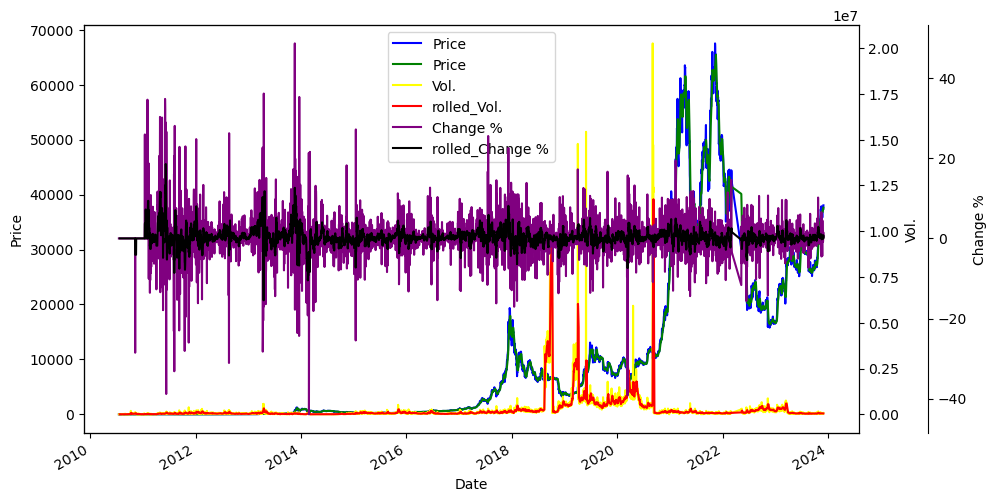

In [90]:
# Plot the rolling mean and original time series
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting 'Price' on the first axis
# bitcoin_df[['Price']].plot(ax=ax1, color='blue', label='Price')
# roll_mean[['Price']].plot(ax=ax1, color='green', label='rolled_price')
# ax1.set_ylabel('Price')

bitcoin_df[['Price']].plot(ax=ax1, color='blue', label='Price')
roll_mean[['Price']].plot(ax=ax1, color='green', label='Rolled Price')
ax1.set_ylabel('Price')

# Create a second y-axis for 'Vol.'
ax2 = ax1.twinx()
bitcoin_df['Vol.'].plot(ax=ax2, color='yellow', label='Vol.')
roll_mean['Vol.'].plot(ax=ax2, color='red', label='rolled_Vol.')
ax2.set_ylabel('Vol.')

# Create a third y-axis for 'Change %'
ax3 = ax1.twinx()
bitcoin_df['Change %'].plot(ax=ax3, color='purple', label='Change %')
roll_mean['Change %'].plot(ax=ax3, color='black', label='rolled_Change %')
ax3.spines['right'].set_position(('outward', 50))  # Adjust position for 'Change %' axis
ax3.set_ylabel('Change %')

# Adjusting layout and legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
ax1.legend(lines, labels, loc='upper center');

Volume and Change features seem to have a seasonality while price has an exponentially increasing trend.

#### <span style="color:blue">DICKEY FULLER TEST</span> <a class="anchor" id="ninth-bullet"></a>

In [91]:
from statsmodels.tsa.stattools import adfuller

dftest_price = adfuller(bitcoin_df['Price'])
dftest_vol = adfuller(bitcoin_df['Vol.'])
dftest_change = adfuller(bitcoin_df['Change %'])

# Extract and display test results in a user friendly manner
for column, item in zip(bitcoin_df.columns, [dftest_price, dftest_vol, dftest_change]):
    dfoutput = pd.Series(item[0:4], index=['Test Statistic', 'p-value', 
                                           '#Lags Used', 'Number of Observations Used'])
    for key, value in item[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(f'Results of Dickey-Fuller test for {column}:')
    print(f'{dfoutput}\n')

Results of Dickey-Fuller test for Price:
Test Statistic                   -1.275208
p-value                           0.640437
#Lags Used                       32.000000
Number of Observations Used    4773.000000
Critical Value (1%)              -3.431721
Critical Value (5%)              -2.862146
Critical Value (10%)             -2.567092
dtype: float64

Results of Dickey-Fuller test for Vol.:
Test Statistic                -8.961191e+00
p-value                        8.215929e-15
#Lags Used                     1.700000e+01
Number of Observations Used    4.788000e+03
Critical Value (1%)           -3.431717e+00
Critical Value (5%)           -2.862144e+00
Critical Value (10%)          -2.567091e+00
dtype: float64

Results of Dickey-Fuller test for Change %:
Test Statistic                -1.773806e+01
p-value                        3.411773e-30
#Lags Used                     1.000000e+01
Number of Observations Used    4.795000e+03
Critical Value (1%)           -3.431715e+00
Critical Value

By applying a **statistical significance level of 0.05**, we can conclude that volume (**p-value=8.215929e-15**) and change (**p-value=3.411773e-30**) are stationary while price (**p-value=0.640437**) is not stationary.

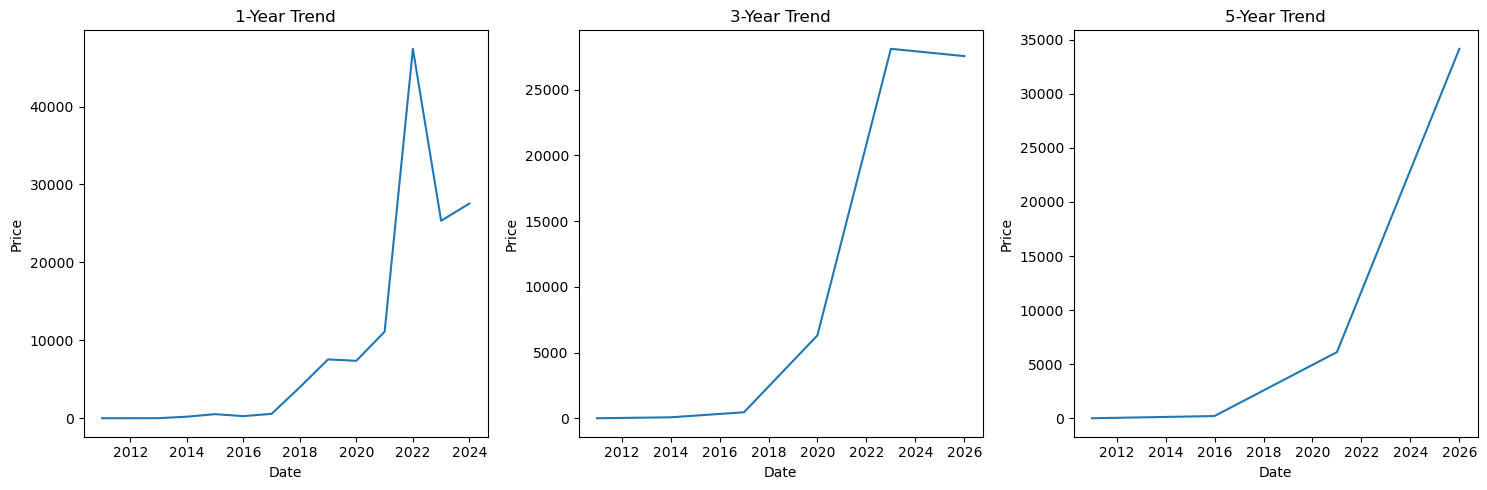

In [92]:
# Visualize 1-year, 3-year, and 5-year trends
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# 1-year trend
sns.lineplot(data=bitcoin_df['Price'].resample('1Y').mean(), ax=axes[0])
axes[0].set_title('1-Year Trend')

# 3-year trend
sns.lineplot(data=bitcoin_df['Price'].resample('3Y').mean(), ax=axes[1])
axes[1].set_title('3-Year Trend')

# 5-year trend
sns.lineplot(data=bitcoin_df['Price'].resample('5Y').mean(), ax=axes[2])
axes[2].set_title('5-Year Trend')

# Adjust layout
plt.tight_layout()
plt.show()

Downsampling the price series to 1-year, 3-year, and 5-year periods shows that it is an exponential trend. We will now decompose the price series to investigate seasonality.

#### <span style="color:blue">TIME SERIES DECOMPOSITION OF THE PRICE FEATURE</span> <a class="anchor" id="ninth-bullet"></a>

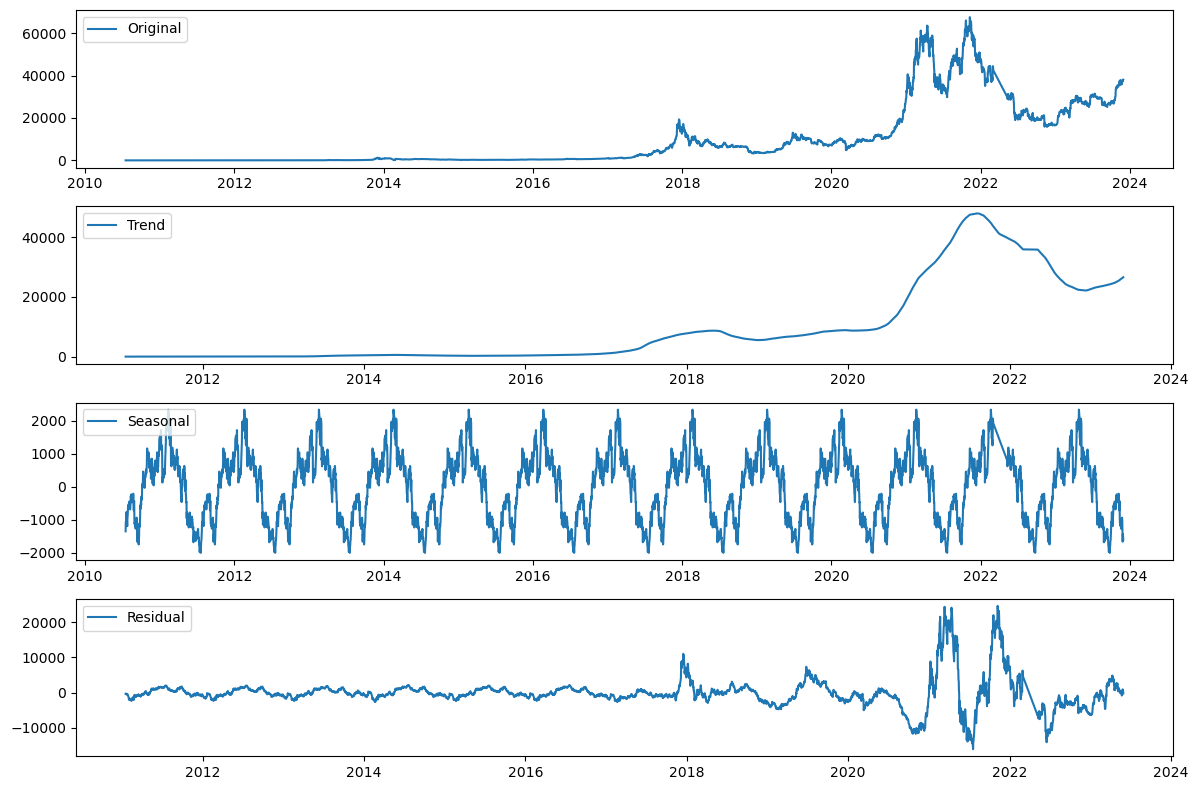

In [93]:
# Checking for Seasonality
# Seasonal decomposition using statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
tsd_result = seasonal_decompose(bitcoin_df['Price'], model='additive', period=365)  # Assuming annual seasonality

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(bitcoin_df['Price'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(tsd_result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(tsd_result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(tsd_result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Time series decomposition reveals that the price feature has a trend and a yearly seasonality.

#### <span style="color:blue">1-LAG DIFFERENCING</span> <a class="anchor" id="ninth-bullet"></a>

We will apply differencing method to detrend the price feature.

In [94]:
# Differencing the price feature
price_diff = bitcoin_df['Price'].diff(periods=1)

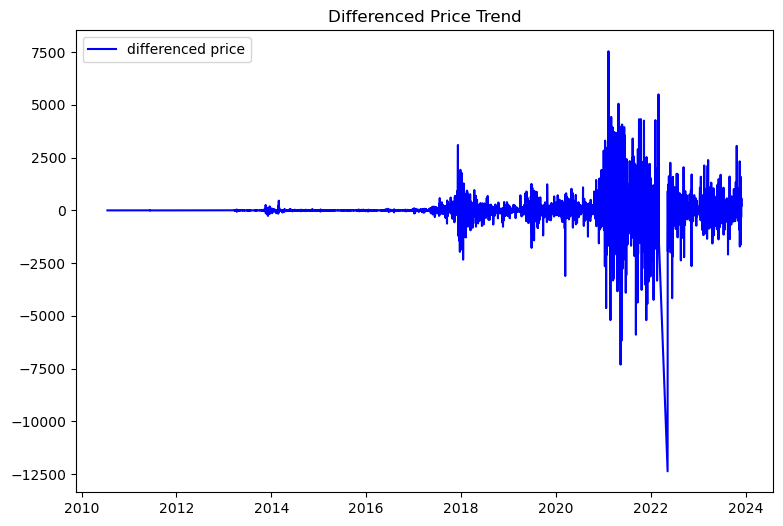

In [95]:
fig = plt.figure(figsize=(9, 6))
plt.plot(price_diff, color='blue',label='differenced price')
plt.legend(loc='best')
plt.title('Differenced Price Trend')
plt.show(block=False);

We will now test for the stationarity of the differenced price feature.

In [96]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(price_diff.dropna())

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print ('Results of Dickey-Fuller test for Price: \n')
print(dfoutput)

Results of Dickey-Fuller test for Price: 

Test Statistic                -1.037870e+01
p-value                        2.167409e-18
#Lags Used                     3.200000e+01
Number of Observations Used    4.772000e+03
Critical Value (1%)           -3.431721e+00
Critical Value (5%)           -2.862146e+00
Critical Value (10%)          -2.567093e+00
dtype: float64


The differenced price feature now has a p-value of 2.167409e-18, which means that it is now stationary.

We will replace the price column in the original dataset with the differenced price and remove rows with null values. 

In [97]:
price_diff

Date
2010-07-18      NaN
2010-07-19      0.0
2010-07-20      0.0
2010-07-21      0.0
2010-07-22      0.0
              ...  
2023-11-25     69.7
2023-11-26   -335.2
2023-11-27   -203.2
2023-11-28    574.7
2023-11-29    223.4
Name: Price, Length: 4806, dtype: float64

In [98]:
# Replace Price feature with differenced price
bitcoin_diff = bitcoin_df.copy()
bitcoin_diff['Price'] = price_diff

# Drop null values
bitcoin_diff.dropna(inplace=True)

## <span style="color:blue">PART 3: TIME SERIES MODELLING</span> <a class="anchor" id="ninth-bullet"></a>

### <span style="color:blue">TRAIN TEST SPLIT</span> <a class="anchor" id="ninth-bullet"></a>

Differencing and time series decomposition have unique strengths and disadvantages.
1-lag differencing helps to remove the linear trend, which is necessary for models such as ARIMA. 
Decomposition helps to remove both the trend and seasonality, which may make the series more stationary for better modelling.

We will therefore, create two sets of train test splits, one for 1-lag differenced series and the other for the residuals.

Since we intend to provide a six-week forecast, we will filter the last six weeks of the data and use it as the test set and the rest of the data will be the training set.

In [99]:
# Train test split for 1-lag differenced series
# Choose a split date
split_date = bitcoin_diff.tail(42).index[0].strftime('%m/%d/%Y') # Get the top 42nd index as a string

# Split train and test data
train_data_diff = bitcoin_diff[bitcoin_diff.index < split_date]
test_data_diff = bitcoin_diff[bitcoin_diff.index >= split_date]

In [100]:
# Train test split for residual series
# Drop null values from residual series
tsd_result.resid.dropna(inplace=True)

# Convert series to a dataframe and rename column as 'Price'
tsd_resid = pd.DataFrame(tsd_result.resid)
tsd_resid.rename(columns={'resid': 'Price'}, inplace=True)
                       
# Choose a split date
split_date_resid = tsd_resid.tail(42).index[0].strftime('%m/%d/%Y') # Get the top 42nd index as a string

# Split train and test data
train_data_resid = tsd_resid[tsd_resid.index < split_date_resid]
test_data_resid = tsd_resid[tsd_resid.index >= split_date_resid]

### <span style="color:blue">BASELINE ARIMA MODEL</span> <a class="anchor" id="ninth-bullet"></a> 

1-lag differencing helps to detrend the data, which is necessary for an ARIMA model. We will therefore, build an auto ARIMA model on the differenced train data.

Test RMSE: 860.367


C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



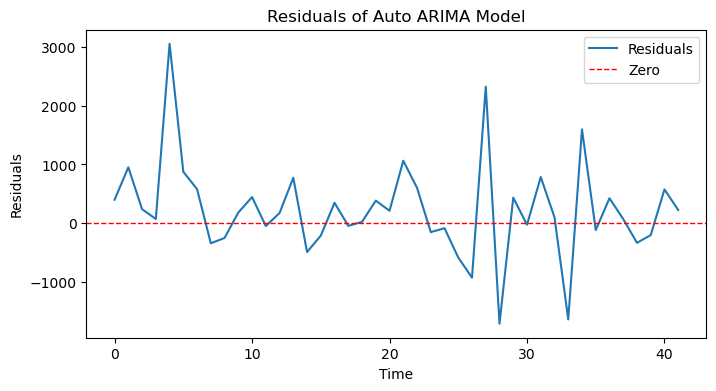

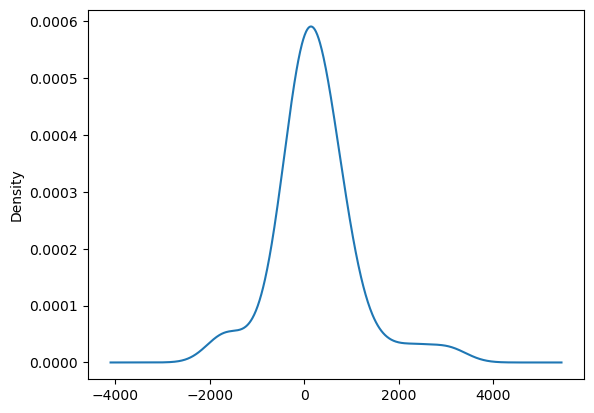

count      42.000000
mean      231.502851
std       838.680195
min     -1713.700000
25%      -143.800000
50%       176.750000
75%       542.050000
max      3057.599999
dtype: float64


In [43]:
# Fit a default auto ARIMA model on training data
model_default = auto_arima(train_data_diff['Price'], seasonal=False)

# Forecasting the same length as the test data
forecast_length = len(test_data_diff)
predictions = model_default.predict(n_periods=forecast_length)

# Calculate residuals
residuals = np.array([x for x in test_data_diff['Price']]) - np.array([x for x in predictions])

# Model evaluation
# Evaluate forecasts
predictions.index = test_data_diff.index
rmse = np.sqrt(mean_squared_error(test_data_diff['Price'], predictions))
print('Test RMSE: %.3f' % rmse)

# Plot residuals
plt.figure(figsize=(8, 4))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.title('Residuals of Auto ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Density plot of residuals
pd.Series(residuals).plot(kind='kde')
pyplot.show()
# Summary stats of residuals
print(pd.Series(residuals).describe())

In [105]:
# Auto ARIMA model with a few adjusted parameters
model_arima= auto_arima(train_data_diff['Price'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=4, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=75319.112, Time=1.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=75344.793, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=75337.708, Time=0.81 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=75338.606, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=75343.181, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=75338.971, Time=0.59 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=75338.126, Time=0.49 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=75315.091, Time=6.43 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=75325.613, Time=1.45 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=75296.014, Time=13.98 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=75314.517, Time=7.11 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=75296.327, Time=15.15 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=75296.425, Time=21.73 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=75297.787, Time=24.99 sec
 

The best model found by the auto ARIMA search has no non-seasonal components (p=0, d=0, q=0), but it includes seasonal components (P=2, D=0, Q=2) with a seasonal period of 12, representing 12 months.

In [106]:
# Summary of fit model
print(model_arima.summary())

                                   SARIMAX Results                                   
Dep. Variable:                             y   No. Observations:                 4763
Model:             SARIMAX(2, 0, [1, 2], 12)   Log Likelihood              -37642.269
Date:                       Sat, 09 Dec 2023   AIC                          75294.538
Time:                               12:11:31   BIC                          75326.881
Sample:                                    0   HQIC                         75305.901
                                      - 4763                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.5746      0.037    -42.792      0.000      -1.647      -1.503
ar.S.L24      -0.7819      0.029    -27.327      0.000      -0.838      -0.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



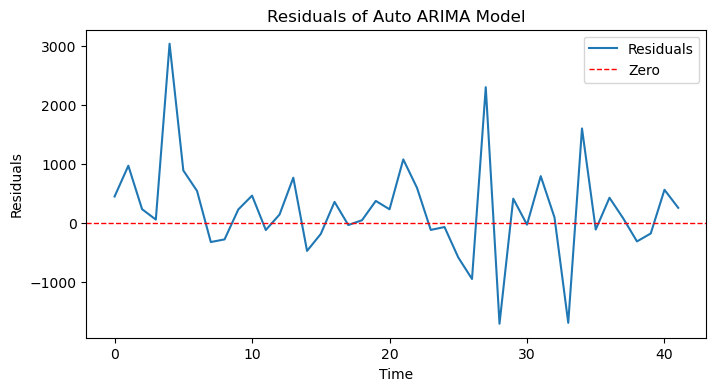

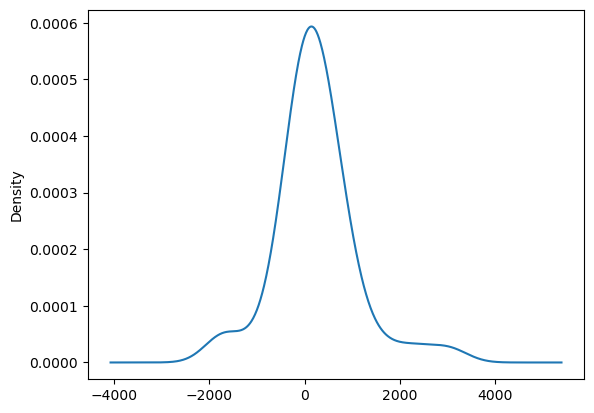

count      42.000000
mean      231.871809
std       837.950863
min     -1708.715949
25%      -120.889190
50%       183.893192
75%       520.177977
max      3034.709970
dtype: float64


In [107]:
# Forecasting the same length as the test data
forecast_length = len(test_data_diff)
predicted_data = model_arima.predict(n_periods=forecast_length)

# Calculate residuals
residuals = np.array([x for x in test_data_diff['Price']]) - np.array([x for x in predicted_data])

# Plot residuals
plt.figure(figsize=(8, 4))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.title('Residuals of Auto ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Density plot of residuals
pd.Series(residuals).plot(kind='kde')
pyplot.show()
# Summary stats of residuals
print(pd.Series(residuals).describe())

The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

Test RMSE: 859.772


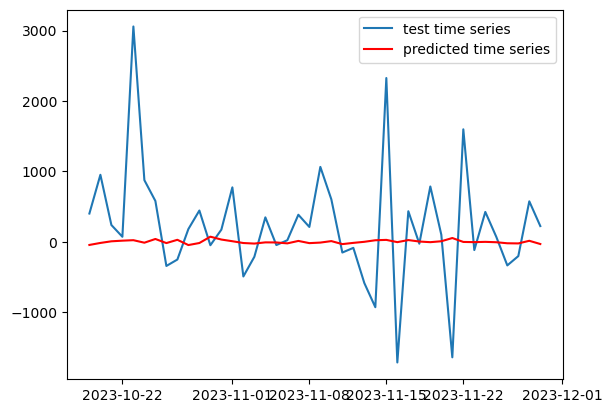

In [108]:
# Model evaluation
# Evaluate forecasts
predicted_data.index = test_data_diff.index
rmse = np.sqrt(mean_squared_error(test_data_diff['Price'], predicted_data))
print('Test RMSE: %.3f' % rmse)
     
# Plot forecasts against actual outcomes
pyplot.plot(test_data_diff['Price'], label= 'test time series')
pyplot.plot(predicted_data, color='red', label='predicted time series')
pyplot.legend()
pyplot.show()

The baseline ARIMA model has an RMSE of 859.772 which is high, and can explain why the predicted series is not as spurious as the original time series.

### <span style="color:blue">SARIMAX MODEL</span> <a class="anchor" id="ninth-bullet"></a>  

SARIMAX models extend the ARIMA framework by seamlessly integrating seasonal patterns and exogenous variables.

From the time series decomposition and auto ARIMA search, we noted that the price feature has a seasonality of one year, which is 365 days based on our series' frequency. 

We will build a SARIMAX model on the differenced series.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                   SARIMAX Results                                   
Dep. Variable:                         Price   No. Observations:                 4763
Model:             SARIMAX(2, 0, [1, 2], 12)   Log Likelihood              -37642.269
Date:                       Mon, 11 Dec 2023   AIC                          75294.538
Time:                               15:47:19   BIC                          75326.881
Sample:                                    0   HQIC                         75305.901
                                      - 4763                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.5746      0.037    -42.792      0.000      -1.647      -1.503
ar.S.L24      -0.7819      0.029    -27.327      0.000      -0.838      -0.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



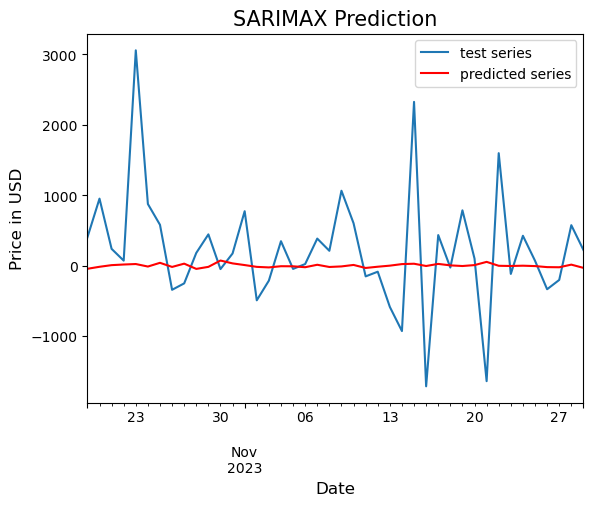

In [120]:
# Set best order as the values obtained via auto ARIMA
non_seasonal_order = (0, 0, 0)
best_seasonal_order = (2, 0, 2, 12)  

# Fit SARIMA model with the best orders on train set
sarimax_model = SARIMAX(train_data_diff['Price'], order=non_seasonal_order, seasonal_order=best_seasonal_order) 
sarima_fit = sarimax_model.fit()

# Display the summary of the model
print(sarima_fit.summary())

# Forecast for the specific number of days
forecast_days = len(test_data_diff)

# Perform the forecast
sarimax_pred = sarima_fit.get_forecast(steps=forecast_days)

# Extract predicted values
predicted_values = sarimax_pred.predicted_mean

# Calculate RMSE 
rmse_arma = np.sqrt(mean_squared_error(test_data_diff['Price'], predicted_values))
print("\n")
print(f"SARIMA Model RMSE: {rmse_arma:.3f}")

# Change the forecast index to match the test data
predicted_values.index = test_data_diff.index

# Plot forecasts against actual outcomes
test_data_diff['Price'].plot(label= 'test series')
predicted_values.plot(color='red', label='predicted series')
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Price in USD', fontsize=12) 
plt.title('SARIMAX Prediction', fontsize=15)
plt.legend()
plt.show()

The SARIMAX model has the same RMSE of 859.772 as the best ARIMA model.

### <span style="color:blue">FACEBOOK PROPHET MODEL</span> <a class="anchor" id="ninth-bullet"></a>  
Prophet is [a procedure for forecasting univariate time series data](https://github.com/facebook/prophet) based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

09:52:40 - cmdstanpy - INFO - Chain [1] start processing
09:52:41 - cmdstanpy - INFO - Chain [1] done processing


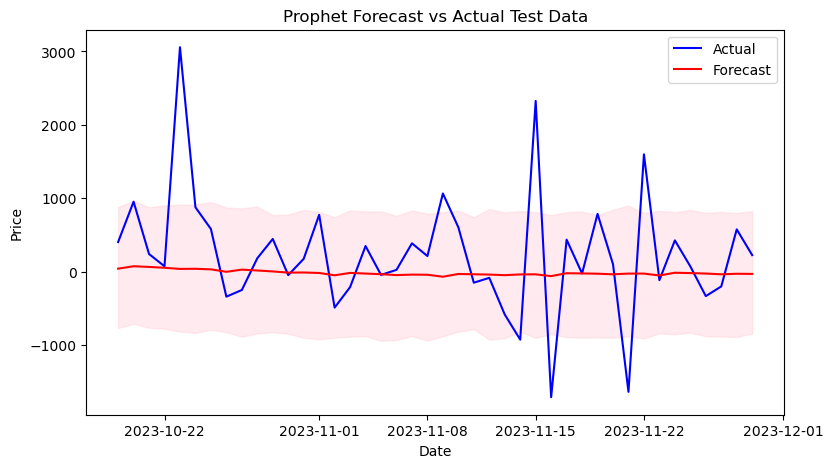

In [45]:
# Facebook model on 1-lag differenced series
# Find the last date in the training data
last_date = train_data_diff.index[-1]

# Increment the last date by one day to get the start date for forecasting
start_date = last_date + pd.DateOffset(days=1)

# Create a DataFrame with future dates starting from the next day
future = pd.DataFrame({'ds': pd.date_range(start=start_date, periods=42)})  # 42 days = 6 weeks

# Create and fit the Prophet model
prophet_data = train_data_diff.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})
fb_model = Prophet()
fb_model.fit(prophet_data)

# Generate forecasts
future_forecast = fb_model.predict(future)

# Plot the forecast vs the test dataset
# Merge the Prophet forecast with the differenced test_data
merged_df = pd.merge(test_data_diff, future_forecast[['ds', 'yhat', 
                                                 'yhat_lower', 'yhat_upper']], 
                     left_index=True, right_on='ds')

# Plot the actual test data and the forecast
plt.figure(figsize=(9, 5))

# Plot the actual test data
plt.plot(merged_df['ds'], merged_df['Price'], label='Actual', color='blue')

# Plot the forecast
plt.plot(merged_df['ds'], merged_df['yhat'], label='Forecast', color='red')

# Fill uncertainty intervals
plt.fill_between(merged_df['ds'], merged_df['yhat_lower'], merged_df['yhat_upper'], 
                 color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Prophet Forecast vs Actual Test Data')
plt.legend();

Facebook prophet model evaluation.

In [277]:
# Evaluate forecasts
# Change the index of forecasted series
future_forecast = future_forecast.set_index('ds')
rmse = np.sqrt(mean_squared_error(test_data_diff['Price'], future_forecast['yhat']))
print('1-lag Differenced Test RMSE: %.3f' % rmse)

1-lag Differenced Test RMSE: 855.996


14:13:48 - cmdstanpy - INFO - Chain [1] start processing
14:13:48 - cmdstanpy - INFO - Chain [1] done processing


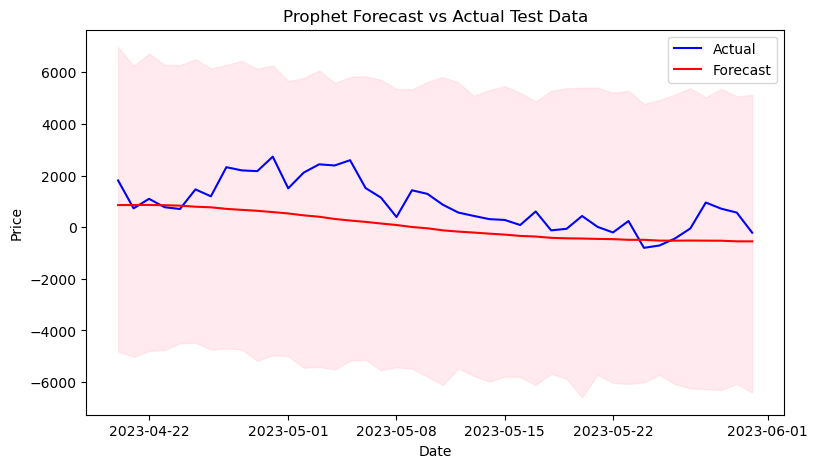

In [271]:
# Facebook model on residual series
# Find the last date in the training data
last_date = train_data_resid.index[-1]

# Increment the last date by one day to get the start date for forecasting
start_date = last_date + pd.DateOffset(days=1)

# Create a DataFrame with future dates starting from the next day
future = pd.DataFrame({'ds': pd.date_range(start=start_date, periods=42)})  # 42 days = 6 weeks

# Create and fit the Prophet model
prophet_data = train_data_resid.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})
fb_model = Prophet()
fb_model.fit(prophet_data)

# Generate forecasts
future_forecast = fb_model.predict(future)

# Plot the forecast vs the test dataset
# Merge the Prophet forecast with the differenced test_data
merged_df = pd.merge(test_data_resid, future_forecast[['ds', 'yhat', 
                                                 'yhat_lower', 'yhat_upper']], 
                     left_index=True, right_on='ds')

# Plot the actual test data and the forecast
plt.figure(figsize=(9, 5))

# Plot the actual test data
plt.plot(merged_df['ds'], merged_df['Price'], label='Actual', color='blue')

# Plot the forecast
plt.plot(merged_df['ds'], merged_df['yhat'], label='Forecast', color='red')

# Fill uncertainty intervals
plt.fill_between(merged_df['ds'], merged_df['yhat_lower'], merged_df['yhat_upper'], 
                 color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Prophet Forecast vs Actual Test Data')
plt.legend();

In [272]:
# Evaluate forecasts
# Change the index of forecasted series
future_forecast = future_forecast.set_index('ds')
rmse = np.sqrt(mean_squared_error(test_data_resid['Price'], future_forecast['yhat']))
print('Residual Test RMSE: %.3f' % rmse)

Residual Test RMSE: 1075.853


The facebook prophet model is performing better on the 1-lag differenced series compared to the residuals. We will therefore go with the model built on the 1-lag differenced series.

The root mean squared error of the differenced series has improved from 859.772 with the ARIMA model to 855.996 with the Facebook Prophet model.

### <span style="color:blue">VECTOR AUTOREGRESSIVE (VAR) MODEL</span> <a class="anchor" id="ninth-bullet"></a> 

It is important to note that the above univariate models for predicting price ingnored the volume and change features.
However, we saw that Price and Change % have a differenced correlation of 0.317 while price and volume have a correlation of 0.001570.

This shows that there might be some level of interdependence between the variables, which means that the future values of each variable are partially influenced by the past values of all the other variables We will therefore, use a VAR algorithm, to model each variable on the past values of itself and the past values of all the other variables.
.


In [101]:
# Fit VAR model
var_model = VAR(train_data_diff)

# Select lag order using information criterion (e.g., AIC)
# Here, using 'aic' to automatically determine the lag order
results = var_model.fit(ic='aic')

# Forecasting for the next 6 weeks (42 days)
forecast_horizon_days = len(test_data_diff)
forecast = results.forecast(train_data_diff.values[-results.k_ar:], 
                            steps=forecast_horizon_days)
forecast_index = pd.date_range(start=train_data_diff.index[-1] +
                               pd.Timedelta(days=1), periods=forecast_horizon_days)

forecast_var = pd.DataFrame(forecast, index=forecast_index, columns=train_data_diff.columns)
print("Forecast:")
print(forecast_var)

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Forecast:
                 Price           Vol.  Change %
2023-10-19   24.395502   91526.599717  0.334374
2023-10-20  -20.153285   96236.202232  0.299168
2023-10-21    2.680849  122546.145883  0.248934
2023-10-22   -8.891328  122246.926860  0.242790
2023-10-23  -60.399313  132705.994283  0.130959
2023-10-24  -21.485627  141448.273730  0.165796
2023-10-25  108.000082  151818.910547  0.562369
2023-10-26   36.847690  168014.189038  0.473541
2023-10-27   -4.143986  166742.621634  0.254172
2023-10-28    4.996376  173744.668936  0.283657
2023-10-29    4.922837  180108.951728  0.316951
2023-10-30    9.573805  186227.340038  0.320649
2023-10-31    8.179393  192634.402515  0.314047
2023-11-01   -3.211097  195698.563891  0.298590
2023-11-02   -3.200629  200582.974814  0.286864
2023-11-03   10.669943  205139.722995  0.314810
2023-11-04   10.339788  210138.958395  0.327191
2023-11-05    5.689469  214155.926299  0.318437
2023-11-06    4.883124  217317.855937  0.309252
2023-11-07    5.093835  220902

In [102]:
# Evaluate VAR forecasts
# Calculate RMSE for each variable
rmse_var1 = mean_squared_error(test_data_diff['Price'], forecast_var['Price'], squared=False)
rmse_var2 = mean_squared_error(test_data_diff['Vol.'], forecast_var['Vol.'], squared=False)
rmse_var3 = mean_squared_error(test_data_diff['Change %'], forecast_var['Change %'], squared=False)

print("RMSE for Price:", rmse_var1)
print("RMSE for Vol.:", rmse_var2)
print("RMSE for Change %:", rmse_var3)

RMSE for Price: 864.513895889938
RMSE for Vol.: 167485.7105998233
RMSE for Change %: 2.51005691575666


RMSE for the price series has slightly increased from 859.772 with the baseline ARIMA model to 864.514 with the VAR model. 

#### <span style="color:blue">Forecast Comparison Plot:</span>

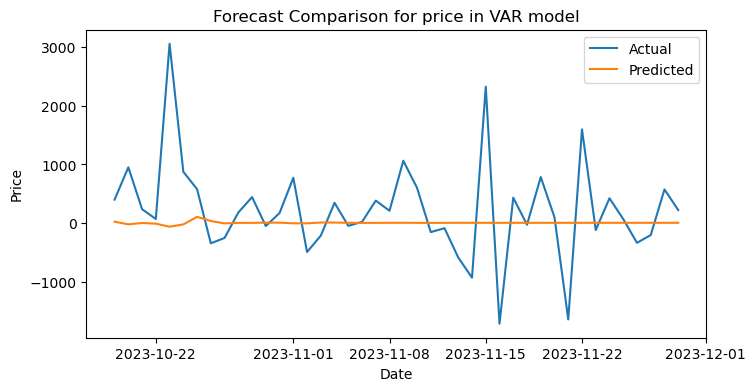

In [103]:
# Plot the predicted values against the actual values
plt.figure(figsize=(8, 4))
plt.plot(test_data_diff.index, test_data_diff['Price'], label='Actual')
plt.plot(test_data_diff.index, forecast_var['Price'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Forecast Comparison for price in VAR model')
plt.legend()
plt.show()

#### <span style="color:blue">Residual visualization</span>

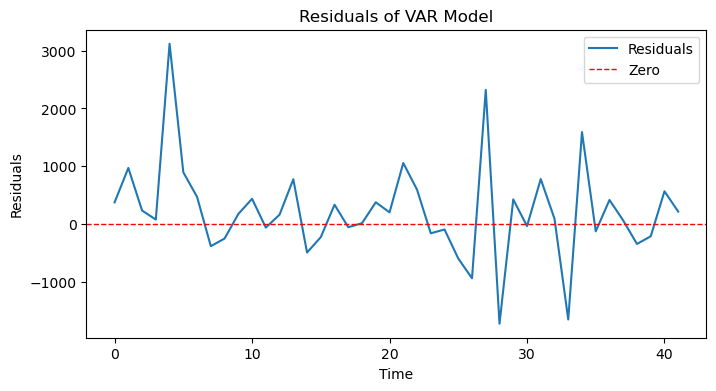

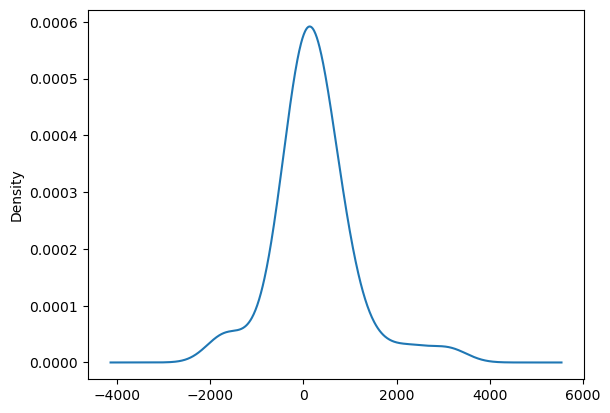

count      42.000000
mean      225.813904
std       844.616799
min     -1719.251462
25%      -148.525972
50%       170.162115
75%       463.644230
max      3117.999313
dtype: float64


In [104]:
# Calculate residuals
residuals = np.array([x for x in test_data_diff['Price']]) - np.array([x for x in forecast_var['Price']])

# Plot residuals
plt.figure(figsize=(8, 4))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.title('Residuals of VAR Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Density plot of residuals
pd.Series(residuals).plot(kind='kde')
pyplot.show()
# Summary stats of residuals
print(pd.Series(residuals).describe())

### <span style="color:blue">MULTIVARIATE LONG SHORT-TERM MEMORY NETWORK (LSTM) MODEL</span> <a class="anchor" id="ninth-bullet"></a> 

The shortcoming of traditional Recurrent Neural Networks (RNN) is that [they cannot remember long-term dependencies](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/) due to vanishing gradient. LSTMs are explicitly designed to avoid long-term dependency problems. This makes LSTM more accurate in time series prediction.


We will build a multivariable time series that will take in the 3 time series (price, volume, and change) and predict the price for next 6 weeks.

Multiple input multi-step univariate output LSTM models.

#### <span style="color:blue">VANILLA (SINGLE LAYER) LSTM MODEL</span> <a class="anchor" id="ninth-bullet"></a> 

In [132]:
# Training vanilla LSTM model on differenced train data

# Define the prediction function
@tf.function
def predict_with_model(model, x_input):
    return model.predict(x_input)

# def split_sequences(sequences, n_steps_in, n_steps_out):
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    
# Define input sequence
in_seq1 = train_data_diff['Price'].values
in_seq2 = train_data_diff['Vol.'].values
out_seq = train_data_diff['Change %'].values

# Define the train array
dataset = np.column_stack((in_seq1, in_seq2, out_seq))

# Adjust sequence length
n_steps_in, n_steps_out = 50, 42

# Convert sequences
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features = X.shape[2]

# Define a single LSTM layer with 50 units
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X, y, epochs=100, batch_size=32, verbose=0)

# Adjust input for prediction
x_input = np.array(train_data_diff[-n_steps_in:]).reshape((1, n_steps_in, n_features))
yhat = model(x_input)
print(yhat)

tf.Tensor(
[[   9.909529  -48.73376    97.58831   -26.496845   53.45746   -22.923033
   -14.241842  -78.801796  -36.14784    13.12053   -53.668636   47.23234
    14.907579  -14.871581   97.97822    22.27975   -25.450344 -137.7537
    49.165333   64.09788    39.960762  -74.60831   -31.076843   26.151384
   -65.215546   26.962694   77.74647   -25.286396  -73.471306   33.981785
    33.34836   -30.613008   60.19111    33.166843   95.96689   -11.116229
   -28.378212   59.96972   -46.73031    20.188744  -43.04749    43.60945 ]], shape=(1, 42), dtype=float32)


In [133]:
# LSTM Model Summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 50)                10800     
                                                                 
 dense_9 (Dense)             (None, 42)                2142      
                                                                 
Total params: 12942 (50.55 KB)
Trainable params: 12942 (50.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Vanilla LSTM RMSE: 860.282


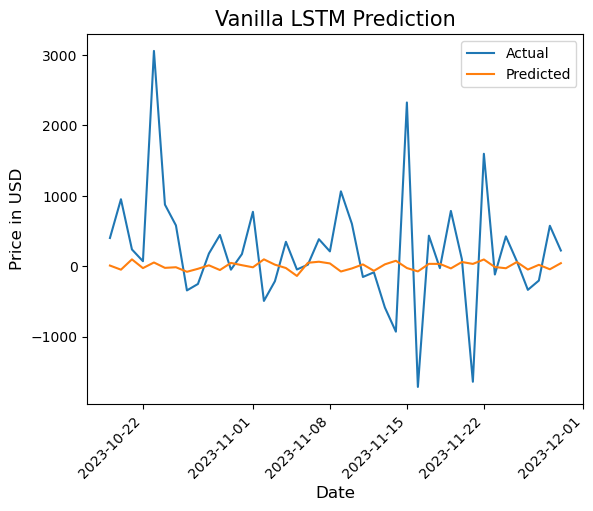

In [139]:
# vanilla LSTM Model Evaluation
# Calculate RMSE for each variable
rmse_lstm = mean_squared_error(test_data_diff['Price'], yhat.numpy().tolist()[0], squared=False)

print('Vanilla LSTM RMSE: %.3f' % rmse_lstm)

# Plot forecasts against actual outcomes
# Convert forecast to dataframe
forecast_lstm = pd.DataFrame(yhat.numpy().tolist()[0])
# Change the forecast index to match the test data
forecast_lstm.index = test_data_diff.index

plt.plot(test_data_diff.index, test_data_diff['Price'], label='Actual')
plt.plot(test_data_diff.index, forecast_lstm, label='Predicted')
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Price in USD', fontsize=12) 
plt.title('Vanilla LSTM Prediction', fontsize=15)
plt.xticks(rotation=45, ha='right') # Rotate xticks
plt.legend()
plt.show()

The vanilla LSTM model has an RMSE score of 860.282

#### <span style="color:blue">STACKED LSTM MODEL</span> <a class="anchor" id="ninth-bullet"></a> 

In [140]:
# Training stacked LSTM model on differenced train data
# Define the prediction function
@tf.function
def predict_with_model(model_2, x_input):
    return model_2.predict(x_input)
    
# def split_sequences(sequences, n_steps_in, n_steps_out):
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    
# define input sequence
in_seq1 = train_data_diff['Price'].values
in_seq2 = train_data_diff['Vol.'].values
out_seq = train_data_diff['Change %'].values

# Define the train array
dataset = np.column_stack((in_seq1, in_seq2, out_seq))

# Adjust sequence length
n_steps_in, n_steps_out = 50, 42

# Convert sequences
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features = X.shape[2]

# Define a single LSTM layer with 50 units
model_2 = Sequential()
model_2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_2.add(LSTM(50, activation='relu'))
model_2.add(Dense(n_steps_out))
model_2.compile(optimizer='adam', loss='mse')

# Fit the model
model_2.fit(X, y, epochs=100, batch_size=32, verbose=0)

# Adjust input for prediction
x_input = np.array(train_data_diff[-n_steps_in:]).reshape((1, n_steps_in, n_features))
yhat_2 = model.predict(x_input, verbose=0)
print(yhat_2)

[[   9.909529  -48.73376    97.58831   -26.496845   53.45746   -22.923033
   -14.241842  -78.801796  -36.14784    13.12053   -53.668636   47.23234
    14.907579  -14.871581   97.97822    22.27975   -25.450344 -137.7537
    49.165333   64.09788    39.960762  -74.60831   -31.076843   26.151384
   -65.215546   26.962694   77.74647   -25.286396  -73.471306   33.981785
    33.34836   -30.613008   60.19111    33.166843   95.96689   -11.116229
   -28.378212   59.96972   -46.73031    20.188744  -43.04749    43.60945 ]]


In [128]:
# Stacked LSTM Model Evaluation
pd.DataFrame(yhat[0])

# Evaluate VAR forecasts
# Calculate RMSE for each variable
rmse_lstm = mean_squared_error(test_data_diff['Price'], yhat[0], squared=False)

print('Stacked LSTM RMSE: %.3f' % rmse_lstm)

Stacked LSTM RMSE: 860.411


The stacked LSTM model has achieved an RMSE score of about 860.411.

#### <span style="color:blue">BIDIRECTIONAL LSTM MODEL</span> <a class="anchor" id="ninth-bullet"></a> 
The [bidirectional LSTM model learns the input sequence both forward and backwards](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/) and concatenates both interpretations. This may lead to better learning and performance compared to unidirectional LSTM.

In [104]:
from keras.layers import Bidirectional

# Define a Bidirectional LSTM layer with 50 units
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X, y, epochs=100, batch_size=32, verbose=0)

# Adjust input for prediction
x_input = np.array(train_data_diff[-n_steps_in:]).reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[-112.19008      6.874629   -49.96967    -49.250843   -81.31148
   107.43868     90.400894   -42.905308   -16.921995   121.073975
    18.884241  -129.83842     10.822048   -68.66138    121.2839
     4.948235   103.19987    -17.452282   100.644135     6.3722095
   -35.52255     84.72351     -2.071274  -111.4605    -107.50653
   -15.946898   -44.484573   113.954796   106.20257   -111.40348
    61.153236   135.24448     91.06119     46.03024     31.616798
    24.036947    36.043507    -7.100719    36.11067     95.60972
   -17.64337    128.43517  ]]


In [105]:
# Bidirectional LSTM Model Evaluation
pd.DataFrame(yhat[0])

# Evaluate VAR forecasts
# Calculate RMSE for each variable
rmse_lstm = mean_squared_error(test_data_diff['Price'], yhat[0], squared=False)

print('Bidirectional LSTM RMSE: %.3f' % rmse_lstm)

Vanilla LSTM RMSE: 860.851


The bidirectional LSTM model has achieved an RMSE score of about 860.851.

## <span style="color:blue">PART 4: MODEL DEPLOYMENT</span> <a class="anchor" id="ninth-bullet"></a>
Our best model so far has been the Facebook prophet which achieved a root mean squared score of 855.996. We will test it in real-time data extraction extraction and forecasting.

The deployed model should be able to extract the most recent data about bitcoins versus USD performance and use it to predict the price for next 6 weeks or more.

The recent historical data will be merged with the cleaned data of the preceding trend.

### <span style="color:blue">TEST CODE FOR SCRAPING REAL-TIME DATA AND FORECASTING PRICES</span> <a class="anchor" id="ninth-bullet"></a>

In [116]:
# TEST CODE FOR SCRAPING REAL-TIME DATA AND RUNNING A MODEL
import requests
from bs4 import BeautifulSoup
from datetime import datetime

# Extract latest bitcoin/USD data from investing.com
url = 'https://www.investing.com/crypto/bitcoin/btc-usd-historical-data'

def scrape_bitcoin_data(url, start_date):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table containing the historical data
    table = soup.find('table', {'class': 'w-full text-xs leading-4 overflow-x-auto freeze-column-w-1'})

    # Extracting data from the table
    bitcoin_data = []
    if table:
        rows = table.find_all('tr')
        for row in rows[1:]:  # Skipping the header row
            columns = row.find_all('td')
            date_str = columns[0].find('time')['datetime']
            date = datetime.strptime(date_str, '%m/%d/%Y').date()
            if date >= start_date:
                price = columns[1].text.strip().replace(',', '')  # Removing commas from price for numeric value
                volume = columns[5].text.strip()
                change = columns[6].text.strip()
                bitcoin_data.append({'Date': date, 'Price': price, 'Vol.': volume, 'Change %': change})

    return bitcoin_data

if __name__ == "__main__":
    date_today = pd.Timestamp.today().date()
    # Extract the last date from the current dataset, format it
    last_date = bitcoin_df.tail(1).index[0]

    # # Extract data only if start date is older than today
    if last_date.date() < date_today:
        # start date is one day after the last date
        last_date_plus_one = last_date + pd.DateOffset(days=1)
        start_date = datetime.strptime(last_date_plus_one.strftime('%m/%d/%Y'), '%m/%d/%Y').date()
        bitcoin_data = pd.DataFrame(scrape_bitcoin_data(url, start_date))
        
        # PREPOROCESSING
        # Delete rows with missing values
        bitcoin_data.dropna(inplace=True)
        # Strip suffix letters from volume column and convert to respective numeric figure
        for index, row in bitcoin_data.iterrows():
            if 'K' in row['Vol.']:
                row_value = round(float(row['Vol.'].strip('K')) * 1000)
                bitcoin_data.at[index, 'Vol.'] = row_value
            elif 'M' in row['Vol.']:
                row_value = round(float(row['Vol.'].strip('M')) * 1000000)
                bitcoin_data.at[index, 'Vol.'] = row_value
            elif 'B' in row['Vol.']:
                row_value = round(float(row['Vol.'].strip('B')) * 1000000000)
                bitcoin_data.at[index, 'Vol.'] = row_value  
                  
        # Remove percentage sign from the 'Change' column
        bitcoin_data['Change %'] = bitcoin_data['Change %'].str.replace('%', '')
        
        # Convert price, volume, and change columns to float
        bitcoin_data[['Price', 'Vol.', 'Change %']] = bitcoin_data[['Price', 'Vol.', 
                                                                    'Change %']].astype(float)
        # Drop duplicate rows
        bitcoin_data.drop_duplicates(inplace=True)
        
        # CONVERTING TO TIME SERIES
        # Convert Date column to time series 
        bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
        
        # Sort by date in descending order
        bitcoin_data.sort_values(by='Date', ascending=True, inplace=True)
        
        # Set date column as the index
        bitcoin_data.set_index('Date', inplace=True)
    
        # REMOVING OUTLIERS
        # Filter rows with volume above 50,000,000
        bitcoin_data = bitcoin_data[bitcoin_data['Vol.'] < 50000000]
        # Filter rows with change below -50% and above 50%
        bitcoin_data = bitcoin_data[(bitcoin_data['Change %'] > -50) & (bitcoin_data['Change %'] < 50)]
        
        # Add the data to the previous preprocessed time series
        bitcoin_df = pd.concat([bitcoin_df, bitcoin_data])

        # REMOVING TRENDS
        # Difference the price column
        price_diff = bitcoin_df['Price'].diff(periods=1)
        # Replace Price column with differenced in a copy of the dataset
        bitcoin_df_copy = bitcoin_df.copy()
        bitcoin_df_copy['Price'] = price_diff 
        # Drop null values
        bitcoin_df_copy.dropna(inplace=True)
                         
    # BUILDING A TIME SERIES MODEL
    # Fetch the last date in the new bitcoin_df_copy time series
    last_day = bitcoin_df_copy.index[-1]
    
    # Increment the last date by one day to get the start date for forecasting
    start_date = last_day + pd.DateOffset(days=1)
    
    # Create a DataFrame with future dates starting from the next day
    future = pd.DataFrame({'ds': pd.date_range(start=start_date, periods=42)})  # Specify the range
    
    # Create and fit the Prophet model
    prophet_data = bitcoin_df_copy.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})
    fb_model = Prophet()
    fb_model.fit(prophet_data)
    
    # Generate forecasts
    fb_forecast = fb_model.predict(future)

    # Rename 'ds' as 'Date'
    fb_forecast = fb_forecast.rename(columns = {'ds': 'Date'})
    
    # Set date column as index
    fb_forecast.set_index('Date', inplace=True)

    # REMOVING 1-LAG DIFFERENCING
    for index, row in fb_forecast.iterrows():
        if index == min(fb_forecast.index):
            # Set the first forecasted value to the last observed price in the bitcoin time series
            true_forecast = bitcoin_df_copy.iloc[-1]['Price'] + fb_forecast.iloc[0]['yhat']
            fb_forecast.at[index, 'yhat'] = true_forecast
        else:
            # Update subsequent forecasted values based on the previous adjusted values
            prev_true_forecast = fb_forecast.at[index - pd.DateOffset(days=1), 'yhat']
            current_yhat = fb_forecast.at[index, 'yhat']
            true_forecast = prev_true_forecast + current_yhat
            fb_forecast.at[index, 'yhat'] = true_forecast

12:14:09 - cmdstanpy - INFO - Chain [1] start processing
12:14:09 - cmdstanpy - INFO - Chain [1] done processing


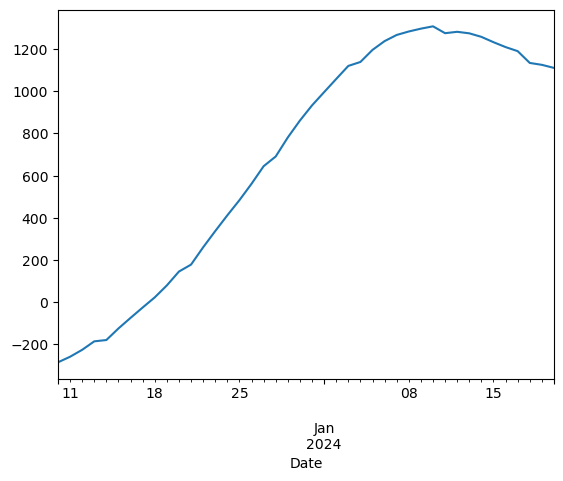

In [117]:
# Plot the future differenced price forecast beginning from the day after the train set
fb_forecast['yhat'].plot();

### <span style="color:blue">WEB SERVER DEPLOYMENT CODE</span> <a class="anchor" id="ninth-bullet"></a>

Our best performing model is the facebook prophet with an RSME of 855.996 on 1-lag differenced data.

However, since we had splitted the data into train and test sets allow for testing, we are going to build the model on the whole dataset and use it for deployment. 

We will create an streamlit app for deployment.

In [52]:
# Building and saving the deployment model
# Create and fit the Prophet model
prophet_data = bitcoin_diff.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})
fb_model = Prophet()
fb_model.fit(prophet_data)

# Create a pickle file for the final model
with open("fb_model.pkl", "wb") as f:
    joblib.dump(fb_model, f)

11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# STREAMLIT APP DEPLOYMENT CODE
import streamlit as st
import joblib
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

"""
## Welcome to Crypto Hub.
*Precise crypto forecasting*

"""

with open('model_test.pkl','rb') as file:
    fb_model = joblib.load(file)


num_of_days = st.number_input('Enter Number of Days to be Predicted from Today')

if st.button("predict"):
    
    # Extract latest bitcoin/USD data from investing.com
    url = 'https://www.investing.com/crypto/bitcoin/btc-usd-historical-data'

    def scrape_bitcoin_data(url, start_date):
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the table containing the historical data
        table = soup.find('table', {'class': 'w-full text-xs leading-4 overflow-x-auto freeze-column-w-1'})

        # Extracting data from the table
        bitcoin_data = []
        if table:
            rows = table.find_all('tr')
            for row in rows[1:]:  # Skipping the header row
                columns = row.find_all('td')
                date_str = columns[0].find('time')['datetime']
                date = datetime.strptime(date_str, '%m/%d/%Y').date()
                if date >= start_date:
                    price = columns[1].text.strip().replace(',', '')  # Removing commas from price for numeric value
                    volume = columns[5].text.strip()
                    change = columns[6].text.strip()
                    bitcoin_data.append({'Date': date, 'Price': price, 'Vol.': volume, 'Change %': change})

        return bitcoin_data

if __name__ == "__main__":
    # CREATE THE INITIAL DATAFRAME
    bitcoin_df = pd.read_csv("bitcoin_data.csv")

    # Convert Date column to time series 
    bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])

    # Set date column as the index
    bitcoin_df.set_index('Date', inplace=True)

    date_today = pd.Timestamp.today().date()
    # Extract the last date from the current dataset, format it
    last_date = bitcoin_df.tail(1).index[0]

    # # Extract data only if start date is older than today
    if last_date.date() < date_today:
        # start date is one day after the last date
        last_date_plus_one = last_date + pd.DateOffset(days=1)
        start_date = datetime.strptime(last_date_plus_one.strftime('%m/%d/%Y'), '%m/%d/%Y').date()
        bitcoin_data = pd.DataFrame(scrape_bitcoin_data(url, start_date))
        
        # PREPOROCESSING
        # Strip suffix letters from volume column and convert to respective numeric figure
        for index, row in bitcoin_data.iterrows():
            if 'K' in row['Vol.']:
                row_value = round(float(row['Vol.'].strip('K')) * 1000)
                bitcoin_data.at[index, 'Vol.'] = row_value
            elif 'M' in row['Vol.']:
                row_value = round(float(row['Vol.'].strip('M')) * 1000000)
                bitcoin_data.at[index, 'Vol.'] = row_value
            elif 'B' in row['Vol.']:
                row_value = round(float(row['Vol.'].strip('B')) * 1000000000)
                bitcoin_data.at[index, 'Vol.'] = row_value  
                  
        # Remove percentage sign from the 'Change' column
        bitcoin_data['Change %'] = bitcoin_data['Change %'].str.replace('%', '')
        
        # Convert price, volume, and change columns to float
        bitcoin_data[['Price', 'Vol.', 'Change %']] = bitcoin_data[['Price', 'Vol.', 
                                                                    'Change %']].astype(float)
        # Drop duplicate rows
        bitcoin_data.drop_duplicates(inplace=True)
        
        # CONVERTING TO TIME SERIES
        # Convert Date column to time series 
        bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
        
        # Sort by date in descending order
        bitcoin_data.sort_values(by='Date', ascending=True, inplace=True)
        
        # Set date column as the index
        bitcoin_data.set_index('Date', inplace=True)
    
        # REMOVING OUTLIERS
        # Filter rows with volume above 50,000,000
        bitcoin_data = bitcoin_data[bitcoin_data['Vol.'] < 50000000]
        # Filter rows with change below -50% and above 50%
        bitcoin_data = bitcoin_data[(bitcoin_data['Change %'] > -50) & (bitcoin_data['Change %'] < 50)]
        
        # Add the data to the previous preprocessed time series
        bitcoin_df = pd.concat([bitcoin_df, bitcoin_data])

        # Update the preprocessed dataset file
        bitcoin_df.to_csv('bitcoin_data.csv')

        # REMOVING TRENDS
        # Difference the price column
        price_diff = bitcoin_df['Price'].diff(periods=1)
        # Replace Price column in a copy of dataset with differenced price
        bitcoin_df_copy = bitcoin_df.copy()
        bitcoin_df_copy['Price'] = price_diff 
        # Drop null values
        bitcoin_df_copy.dropna(inplace=True)
                         
    # BUILDING A TIME SERIES MODEL
    # Fetch the last date in the new bitcoin time series
    last_day = bitcoin_df.index[-1]
    
    # Increment the last date by one day to get the start date for forecasting
    start_date = last_day + pd.DateOffset(days=1)

    # Create a DataFrame with future dates starting from the next day
    future = pd.DataFrame({'ds': pd.date_range(start=start_date, periods=num_of_days)})

    # Generate forecasts
    fb_forecast = fb_model.predict(future)

    # Rename 'ds' as 'Date'
    fb_forecast = fb_forecast.rename(columns = {'ds': 'Date'})
    
    # Set date column as index
    fb_forecast.set_index('Date', inplace=True)

    # REMOVING 1-LAG DIFFERENCING
    for index, row in fb_forecast.iterrows():
        if index == min(fb_forecast.index):
            # Set the first forecasted value to the last observed price in the bitcoin time series
            true_forecast = bitcoin_df.iloc[-1]['Price'] + fb_forecast.iloc[0]['yhat']
            fb_forecast.at[index, 'yhat'] = true_forecast
        else:
            # Update subsequent forecasted values based on the previous adjusted values
            prev_true_forecast = fb_forecast.at[index - pd.DateOffset(days=1), 'yhat']
            current_yhat = fb_forecast.at[index, 'yhat']
            true_forecast = prev_true_forecast + current_yhat
            fb_forecast.at[index, 'yhat'] = true_forecast

    """
    ## Number of Days to be Predicted
    """
    num_of_days

    """
    ## Predicted Bitcoin Prices in USD
    """

    fb_forecast['yhat']
    
    # Plotting using matplotlib to customize axis labels
    plt.figure(figsize=(10, 6))
    plt.gca().set_facecolor('lightpink') 
    plt.plot(fb_forecast.index, fb_forecast['yhat'])
    plt.xlabel('Date', fontsize=12)  # Set xlabel
    plt.ylabel('Predicted Price in USD', fontsize=12)  # Set ylabel
    plt.title('Forecasted Bitcoin Prices', fontsize=15)  # Set plot title
    plt.xticks(rotation=45, ha='right') # Rotate xticks
    st.pyplot(plt)  # Display the plot in Streamlit

## <span style="color:blue">CONCLUSION</span> <a class="anchor" id="ninth-bullet"></a>
From our time series analysis and modelling we have found the following:
1. Bitcoin price and volume of trade first rose unnoticeably slowly from 2010 - when it started trading - and then exponentially from 2018 to reach peak price and volume between February and March 2022.
2. The sudden spike in prices in February and March 2022 happened alongside other monumental events such as the Russian invasion of Ukraine and the collapse of the fraudulent FTX trading platform. However, we could not establish the causation between these events and bitcoin performance.
3. Time series decomposition of price reveals that it currently has an exponentially rising trend and is likely to hit the highest-ever peak in a few months. Decomposition also reveals that price has an annual seasonality pattern.
4. There is a near-perfect correlation (0.999) between the opening, high, low, and the final bitcoin price in a day. Therefore, the final price is sufficient to represent the other three trends when analyzing and predicting Bitcoin vs USD performance.
5. The correlation between price and trading volume is about -0.007800 while that between price and percentage change in price is about -0.010. This means that these two features have little influence on the future price of a bitcoin. This has been proved by the fact that our multivariate time series models such as VAR and LSTM did not return a better performance than univariate models.
6. The differenced autocorrelation of price is not statistically significant. This means that the present price is not a significant indicator of the future price.
7. It is possible to predict the future USD price of a bitcoin with an average deviation (RMSE) of about \\$855. Our best-performing model is the Facebook Prophet model.

## <span style="color:blue">LIMITATIONS/ ASSUMPTIONS</span> <a class="anchor" id="ninth-bullet"></a>
1. In some of our models such as the ARIMA, and Facebook Prophet, we assumed that the variables (eg price and change %) are independent of each other. 

2. There was only a single brief period when the volume of trade spiked above 50,000,000 and only single period when the percentage change spiked above 50% and below -50%. In light of this, we assumed that in the future data, any value outside either of the two bands would be considered an outlier. However, we recognize the fact that the future trend may be different, which means that the model will filter what won’t be an outlier at that point in time. 

3. We assumed that the future values of price will not be stationary and that the future values of volume and change will be stationary.

4. Scraping of real time data is dependent on an unchanged design of the source website. If investing.com were to redesign the data pages, then the html tags of the tables would change and our scraping code would no longer work.

## <span style="color:blue">RECOMMENDATIONS FOR FUTURE MODELLING</span> <a class="anchor" id="ninth-bullet"></a>
1. To develop a model that can test for the trend and seasonality of features in future real-time data and remove them if they are there. It should perform different forecasting tests and present a user with the most accurate prediction.
   
2. To develop a model that can detect and adjust to future trends in data. For example, if the price of a bitcoin keeps rising, then what we are filtering as an outlier today will no longer be an outlier in the near future.